In [ ]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge                 # 모델 성능평가 라이브러리

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

from pathlib import Path
from transformers import BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datetime import datetime
from difflib import SequenceMatcher
from collections import Counter
from itertools import tee, islice

import wandb
wandb.login(key="")                     # API KEY 입력

# wandb 꺼두기
os.environ["WANDB_DISABLED"] = "true"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bubblekid43 (aistages-nlp-3). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc


### Config 정의

In [3]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")

In [4]:
config_data = {
    "general": {
        "data_path": "../data/",
        "data_raw_path": "../data/raw/",
        "data_processed_path": "../data/processed/",                                       
        "model_name": "digit82/kobart-summarization",
        "output_dir": "../outputs/checkpoints/"                                 
    },
    "tokenizer": {
        "encoder_max_len": 512,
        "decoder_max_len": 100,
        "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        "special_tokens": ['#Person1#', '#Person2#', '#Person3#',
                           '#PhoneNumber#', '#Address#', '#PassportNumber#']    # 특정 단어들이 분해되지 않도록 하기 위함
    },
    "training": {
        "overwrite_output_dir": True,
        "num_train_epochs": 20,
        "learning_rate": 1e-5,
        "per_device_train_batch_size": 50,
        "per_device_eval_batch_size": 32,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "lr_scheduler_type": 'cosine',
        "optim": 'adamw_torch',
        "gradient_accumulation_steps": 1,
        "evaluation_strategy": 'epoch',
        "save_strategy": 'epoch',
        "save_total_limit": 5,
        "fp16": True,
        "load_best_model_at_end": True,
        "seed": 42,
        "logging_dir": "./logs",
        "logging_strategy": "epoch",
        "predict_with_generate": True,
        "generation_max_length": 100,
        "do_train": True,
        "do_eval": True,
        "early_stopping_patience": 3,
        "early_stopping_threshold": 0.001,
        "report_to": "none"  
        # "report_to": "wandb"                                                        # wandb 사용 옵션
    },
    "wandb": {
        # "entity": "bubblekid43",                                                   
        "project": "NLP-private",                                                   
        "name": "preprocessed_v1"                                                       # 버전관리
    },
    "inference": {
        "ckt_path": "../outputs/checkpoints/",                                      
        "result_path": "../outputs/prediction/",
        "no_repeat_ngram_size": 2,
        "early_stopping": True,
        "generate_max_length": 100,
        "num_beams": 4,
        "batch_size" : 32,
        "remove_tokens": ['<usr>', f"{tokenizer.bos_token}",
                          f"{tokenizer.eos_token}", f"{tokenizer.pad_token}"]       # 불필요한 생성 토큰 정의
    },
}

In [5]:
# 모델의 구성 정보를 YAML 파일로 저장
config_path = "../configs/config.yaml"                                            # 버전관리
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)
print(f"💾 config 저장 완료 : {config_path}")

# 저장된 config 파일 불러와서 내용 확인
with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)
print("\n🔍 config 구성 정보 확인")
print(loaded_config)

💾 config 저장 완료 : ../configs/config.yaml

🔍 config 구성 정보 확인
{'general': {'data_path': '../data/', 'data_processed_path': '../data/processed/', 'data_raw_path': '../data/raw/', 'model_name': 'digit82/kobart-summarization', 'output_dir': '../outputs/checkpoints/'}, 'inference': {'batch_size': 32, 'ckt_path': '../outputs/checkpoints/', 'early_stopping': True, 'generate_max_length': 100, 'no_repeat_ngram_size': 2, 'num_beams': 4, 'remove_tokens': ['<usr>', '<s>', '</s>', '<pad>'], 'result_path': '../outputs/prediction/'}, 'tokenizer': {'bos_token': '<s>', 'decoder_max_len': 100, 'encoder_max_len': 512, 'eos_token': '</s>', 'special_tokens': ['#Person1#', '#Person2#', '#Person3#', '#PhoneNumber#', '#Address#', '#PassportNumber#']}, 'training': {'do_eval': True, 'do_train': True, 'early_stopping_patience': 3, 'early_stopping_threshold': 0.001, 'evaluation_strategy': 'epoch', 'fp16': True, 'generation_max_length': 100, 'gradient_accumulation_steps': 1, 'learning_rate': 1e-05, 'load_best_model_

### 데이터 로드

In [6]:
# 데이터 경로 정의
data_path = Path(loaded_config['general']['data_path'])
data_processed_path = Path(loaded_config['general']['data_processed_path'])

In [7]:
# train data
train_df = pd.read_csv(data_processed_path /'preprocessed_v2' / 'train_preprocessed_v2_input_only.csv')     # 버전관리
print('✅ train_df :', train_df.shape)
display(train_df.head())

✅ train_df : (12410, 4)


,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...",건강검진
1,train_1,"#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...","Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...",백신 접종
2,train_2,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 떤 종...",#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...,열쇠 분실
3,train_3,#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미...,#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...,여자친구와의 결혼
4,train_4,"#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n...","Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하...",춤 제안


In [8]:
# validation data
val_df = pd.read_csv(data_processed_path / 'preprocessed_v2' / 'dev_preprocessed_v2_input_only.csv')     # 버전관리
print('✅ val_df :', val_df.shape)
display(val_df.head())

✅ val_df : (498, 4)


,fname,dialogue,summary,topic
0,dev_0,"#Person1#: 안녕하세요, 오늘 기분이 어떠세요?\n#Person2#: <AC...",#Person2#는 숨쉬기 어려워합니다. 의사는 #Person2#에게 증상을 확인하...,의사 상담
1,dev_1,"#Person1#: 야 Jimmy, 오늘 좀 이따 운동하러 가자.\n#Person2...",#Person1#는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.,운동 계획
2,dev_2,#Person1#: 나 진짜 건강에 안 좋은 음식 좀 그만 먹어야겠어.\n#Pers...,"#Person1#은 건강에 안 좋은 음식을 그만 먹기로 결심하고, #Person2#...",건강한 식단
3,dev_3,"#Person1#: <ACK>\n#Person2#: 당연하지, 있는 거 아냐.\n#...",#Person2#는 UFO를 믿고 꿈에서 볼 수 있다고 한다. #Person1#은 ...,UFO와 외계인
4,dev_4,#Person1#: <ACK>\n#Person2#: 당연히 갔지. 너는?\n#Per...,"#Person1#은 오늘 학교에 가지 않았고, #Person2#는 내일 학교 대신 ...",학교와 주말 계획


In [9]:
# test data
test_df = pd.read_csv(data_processed_path / 'preprocessed_v2' / 'test_preprocessed_v2_input_only.csv')   # 버전관리
print('✅ test_df:', test_df.shape)
display(test_df.head())

✅ test_df: (499, 2)


,fname,dialogue
0,test_0,"#Person1#: Ms. Dawson, 받아쓰기 좀 부탁드려야겠어요.\n#Pers..."
1,test_1,#Person1#: 드디어 왔네! 뭐가 이렇게 오래 걸렸어?\n#Person2#: ...
2,test_2,"#Person1#: Kate, 여기서 일어난 일을 믿기 힘들 거야.\n#Person..."
3,test_3,"#Person1#: 생일 축하해, 이거 너를 위한 선물이야, Brian.\n#Per..."
4,test_4,#Person1#: 이 올림픽 공원 정말 크다!\n#Person2#: 맞아. 지금 ...


### EDA 설정

In [10]:
#========== dialogue ==========#

# 각 줄의 좌우 공백 찾는 함수
def has_leading_or_trailing_spaces(text: str) -> bool:
    return any(
        (line.startswith(" ") or line.endswith(" "))
        for line in text.split("\n")
    )

# 연속 공백(2칸 이상) 찾는 함수
def has_multi_spaces(text: str) -> bool:
    return bool(re.search(r"[ \t]{2,}", text))

#========== summary ==========#

# Summary 문장 수 (한 문장 위주인지 확인) -> 거의 한 문장이라고 봐야할 듯
def count_sentences(text: str) -> int:
    if not isinstance(text, str):
        return 0
    # 마침표/물음표/느낌표 기준으로 대략 문장 수 세기
    parts = re.split(r"[.!?]\s*", text.strip())
    # 빈 문자열 제거
    parts = [p for p in parts if p]
    return len(parts)

# Summary가 대화의 “어느 위치” 정보를 반영하는지 분석
def split_turns(dialogue):
    return [t.strip() for t in dialogue.split("\n") if t.strip()] # 발화 단위로 분리

# Summary와 가장 유사한 turn이 처음, 중간, 끝 중 어디에 위치하는지
def find_related_turn(dialogue, summary):
    turns = split_turns(dialogue)
    sims = []
    for i, turn in enumerate(turns):
        ratio = SequenceMatcher(None, turn, summary).ratio()
        sims.append((i, ratio))
    best = max(sims, key=lambda x: x[1])
    return best  # (turn_index, similarity_score)

# Summary에 남는 / 삭제되는 키워드 확인하는 함수
def simple_tokenize(text: str):
    text = text.lower()
    text = re.sub(r"[^가-힣A-Za-z0-9 ]", " ", str(text))
    text = re.sub(r"\s+", " ", text).strip()
    if not text:
        return []
    tokens = text.split(" ")
    return tokens

def keyword_mapping(dialogue, summary):
    d_words = set(simple_tokenize(dialogue))
    s_words = set(simple_tokenize(summary))

    kept = s_words & d_words
    dropped = d_words - s_words
    
    return list(kept), list(dropped)

# Summary 종결 표현 스타일
def get_ending(text: str, n_chars: int = 3) -> str:
    if not isinstance(text, str) or not text.strip():
        return ""
    t = text.strip()
    # 너무 짧으면 전체 반환
    if len(t) <= n_chars:
        return t
    return t[-n_chars:]

#========== topic ==========#

# Topic과 Summary 관계
def topic_in_summary(row):
    topic = str(row["topic"])
    summ = str(row["summary"])
    return topic in summ

# topic별로 패턴 대략 보는 코드
def topic_coverage_ratio(row):
    topic_tokens = simple_tokenize(str(row["topic"]))
    summary_tokens = simple_tokenize(str(row["summary"]))

    if not topic_tokens:
        return 0.0

    covered = 0
    for tt in topic_tokens:
        # 부분 일치 또는 완전 일치 모두 인정
        if any((tt in st) or (st in tt) for st in summary_tokens):
            covered += 1

    return covered / len(topic_tokens)

# 유니그램/바이그램 overlap 계산 함수
def make_bigrams(tokens: list[str]) -> list[tuple[str, str]]:
    if len(tokens) < 2:
        return []
    t1, t2 = tee(tokens)
    next(t2, None)
    return list(zip(t1, t2))

def lexical_overlap(dialogue: str, summary: str) -> dict:
    d_tokens = simple_tokenize(dialogue)
    s_tokens = simple_tokenize(summary)
    
    d_set = set(d_tokens)
    s_set = set(s_tokens)
    
    # 유니그램 overlap (요약 토큰 기준 커버리지)
    if len(s_set) > 0:
        uni_overlap_ratio = len(d_set & s_set) / len(s_set)
    else:
        uni_overlap_ratio = 0.0

    # bigram overlap
    d_bi = set(make_bigrams(d_tokens))
    s_bi = set(make_bigrams(s_tokens))
    if len(s_bi) > 0:
        bi_overlap_ratio = len(d_bi & s_bi) / len(s_bi)
    else:
        bi_overlap_ratio = 0.0
    
    return {
        "uni_overlap": uni_overlap_ratio,
        "bi_overlap": bi_overlap_ratio,
        "summary_uniq_tokens": len(s_set),
        "dialogue_uniq_tokens": len(d_set),
    }

In [11]:
#========== dialogue ==========#
# dialogue 길이
train_df["dialogue_len"] = train_df["dialogue"].str.len()
val_df["dialogue_len"] = val_df["dialogue"].str.len()
test_df["dialogue_len"] = test_df["dialogue"].str.len()
train_df["dialogue_len_token"] = train_df["dialogue"].str.split().str.len()
val_df["dialogue_len_token"] = val_df["dialogue"].str.split().str.len()
test_df["dialogue_len_token"] = test_df["dialogue"].str.split().str.len()

# dialogue 공백
train_df["d_has_space_edges"] = train_df["dialogue"].apply(has_leading_or_trailing_spaces)
val_df["d_has_space_edges"] = val_df["dialogue"].apply(has_leading_or_trailing_spaces)
test_df["d_has_space_edges"] = test_df["dialogue"].apply(has_leading_or_trailing_spaces)

train_df["d_has_multi_spaces"] = train_df["dialogue"].apply(has_multi_spaces)
val_df["d_has_multi_spaces"] = val_df["dialogue"].apply(has_multi_spaces)
test_df["d_has_multi_spaces"] = test_df["dialogue"].apply(has_multi_spaces)

#========== summary ==========#
# summary 길이
train_df["summary_n_sent"] = train_df["summary"].apply(count_sentences)
val_df["summary_n_sent"] = val_df["summary"].apply(count_sentences)
train_df["summary_len"] = train_df["summary"].str.len()
val_df["summary_len"] = val_df["summary"].str.len()

# dialogue 대비 summary 길이 (요약 압축률)
train_df["len_ratio"] = train_df["summary_len"] / train_df["dialogue_len"]
val_df["len_ratio"] = val_df["summary_len"] / val_df["dialogue_len"]

# dialogue ↔ summary lexical overlap 분석
lexical_df = train_df.apply(lambda row: lexical_overlap(row["dialogue"], row["summary"]), axis=1)
lexical_df = pd.DataFrame(list(lexical_df))
train_df = pd.concat([train_df, lexical_df], axis=1)
lexical_df = val_df.apply(lambda row: lexical_overlap(row["dialogue"], row["summary"]), axis=1)
lexical_df = pd.DataFrame(list(lexical_df))
val_df = pd.concat([val_df, lexical_df], axis=1)

# summary 공백
train_df["s_has_space_edges"] = train_df["summary"].apply(has_leading_or_trailing_spaces)
val_df["s_has_space_edges"] = val_df["summary"].apply(has_leading_or_trailing_spaces)

train_df["s_has_multi_spaces"] = train_df["summary"].apply(has_multi_spaces)
val_df["s_has_multi_spaces"] = val_df["summary"].apply(has_multi_spaces)

train_df["s_has_p1"] = train_df["summary"].str.contains("#Person1#")
train_df["s_has_p2"] = train_df["summary"].str.contains("#Person2#")
val_df["s_has_p1"] = val_df["summary"].str.contains("#Person1#")
val_df["s_has_p2"] = val_df["summary"].str.contains("#Person2#")

# summary와 제일 유사한 dialogue 줄
train_df["summary_main_turn"] = train_df.apply(lambda r: find_related_turn(r["dialogue"], r["summary"])[0], axis=1)
val_df["summary_main_turn"] = val_df.apply(lambda r: find_related_turn(r["dialogue"], r["summary"])[0], axis=1)

# summary에 남는 or 삭제되는 키워드
train_df["keywords_kept"], train_df["keywords_dropped"] = zip(*train_df.apply(lambda r: keyword_mapping(r["dialogue"], r["summary"]), axis=1))
val_df["keywords_kept"], val_df["keywords_dropped"] = zip(*val_df.apply(lambda r: keyword_mapping(r["dialogue"], r["summary"]), axis=1))

# summary 종결 표현
train_df["summary_ending3"] = train_df["summary"].apply(lambda x: get_ending(x, 3))
train_df["summary_ending2"] = train_df["summary"].apply(lambda x: get_ending(x, 2))
val_df["summary_ending3"] = val_df["summary"].apply(lambda x: get_ending(x, 3))
val_df["summary_ending2"] = val_df["summary"].apply(lambda x: get_ending(x, 2))

#========== topic ==========#
train_df["topic_stripped"] = train_df["topic"].astype(str).str.strip()      # 앞뒤 공백 제거한 버전
val_df["topic_stripped"] = val_df["topic"].astype(str).str.strip()
train_df["topic_len"] = train_df["topic_stripped"].str.len()                # topic 길이
val_df["topic_len"] = val_df["topic_stripped"].str.len()

# Topic이 summary 안에 직접 등장하는지 여부
train_df["topic_in_summary"] = train_df.apply(topic_in_summary, axis=1)
val_df["topic_in_summary"] = val_df.apply(topic_in_summary, axis=1)

# topic token이 summary에서 몇 % 커버되는지
train_df["topic_coverage"] = train_df.apply(topic_coverage_ratio, axis=1)
val_df["topic_coverage"] = val_df.apply(topic_coverage_ratio, axis=1)

In [12]:
#========== 컬럼 순서 지정 ==========#
# train, val
cols_train=[
    "fname",
    "dialogue",
    "dialogue_len",
    "dialogue_len_token",
    "d_has_space_edges",
    "d_has_multi_spaces",
    "summary",
    "summary_n_sent",
    "summary_len",
    "len_ratio",
    "uni_overlap", "bi_overlap",
    "s_has_space_edges",
    "s_has_multi_spaces",
    "s_has_p1",
    "s_has_p2",
    "summary_main_turn",
    "keywords_kept",
    "keywords_dropped",
    "summary_ending3",
    "summary_ending2",
    "topic",
    "topic_stripped",
    "topic_len",
    "topic_in_summary",
    "topic_coverage",
]

# test
cols_test=[
    "fname",
    "dialogue",
    "dialogue_len",
    "dialogue_len_token",
    "d_has_space_edges",
    "d_has_multi_spaces",
]

In [13]:
# 데이터 살펴보기
print('✅ train_df :', train_df[cols_train].shape)
display(train_df[cols_train].head())

print('✅ val_df :', val_df[cols_train].shape)
display(val_df[cols_train].head())

print('✅ test_df:', test_df[cols_test].shape)
display(test_df[cols_test].head())

✅ train_df : (12410, 26)


,fname,dialogue,dialogue_len,dialogue_len_token,d_has_space_edges,d_has_multi_spaces,summary,summary_n_sent,summary_len,len_ratio,...,summary_main_turn,keywords_kept,keywords_dropped,summary_ending3,summary_ending2,topic,topic_stripped,topic_len,topic_in_summary,topic_coverage
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...",481,99,False,False,"Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...",3,80,0.166320,...,0,"[dr, mr, 매년]","[정보를, 시도했는데, 볼까요, 본인을, 주된, 약물들이, 특별히, 원인인, 좀, ...",니다.,다.,건강검진,건강검진,4,True,1.0
1,train_1,"#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...",433,92,False,False,"Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...",3,80,0.184758,...,1,"[dr, mrs, 백신]","[맞으러, 지내고, ricky, 저희, 나머지를, 잡아주세요, 맞고, 지금은, 할,...",니다.,다.,백신 접종,백신 접종,5,True,1.0
2,train_2,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 떤 종...",276,49,False,False,#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...,1,54,0.195652,...,0,"[person2, person1, 열쇠]","[아니에요, 할지, 적, 처음이라서요, 다섯, 어떻게, 열쇠요, 감사해야, 모르겠네...",니다.,다.,열쇠 분실,열쇠 분실,5,False,0.5
3,train_3,#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미...,311,63,False,False,#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...,1,61,0.196141,...,0,"[person2, 결혼할, person1, 가]","[알았어, 있는, 했잖아, 내가, 왜, 했었나, 중요하지, 말하잖아, 남자들, 말,...",니다.,다.,여자친구와의 결혼,여자친구와의 결혼,9,False,0.5
4,train_4,"#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n...",268,53,False,False,"Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하...",1,59,0.220149,...,5,[발을],"[person2, 알려드릴게요, 곡, 저랑, 될까요, 제가, 반가워요, 밟아도, 친...",니다.,다.,춤 제안,춤 제안,4,False,1.0


✅ val_df : (498, 26)


,fname,dialogue,dialogue_len,dialogue_len_token,d_has_space_edges,d_has_multi_spaces,summary,summary_n_sent,summary_len,len_ratio,...,summary_main_turn,keywords_kept,keywords_dropped,summary_ending3,summary_ending2,topic,topic_stripped,topic_len,topic_in_summary,topic_coverage
0,dev_0,"#Person1#: 안녕하세요, 오늘 기분이 어떠세요?\n#Person2#: <AC...",293,57,False,False,#Person2#는 숨쉬기 어려워합니다. 의사는 #Person2#에게 증상을 확인하...,2,78,0.266212,...,8,"[천식, person2, 전문의에게, 폐, 검사를, 위해]","[숨쉴, 없어요, 있는, 답답해요, 기분이, 아니면, 많이, 특별히, 최근에, 그래...",니다.,다.,의사 상담,의사 상담,5,False,0.500000
1,dev_1,"#Person1#: 야 Jimmy, 오늘 좀 이따 운동하러 가자.\n#Person2...",275,58,False,False,#Person1#는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.,1,48,0.174545,...,0,"[복근, 운동하러, person1]","[person2, 있어, 때문에, 알았어, 운동하는, 야, 좀, 좋아, 갈래, 다리...",니다.,다.,운동 계획,운동 계획,5,False,0.500000
2,dev_2,#Person1#: 나 진짜 건강에 안 좋은 음식 좀 그만 먹어야겠어.\n#Pers...,297,58,False,False,"#Person1#은 건강에 안 좋은 음식을 그만 먹기로 결심하고, #Person2#...",1,78,0.262626,...,0,"[그만, person2, 안, 좋은, person1, 건강에]","[건강하게, 먹으면, 채소는, 다야, 무슨, 건강해, 과일이랑, 보이네, 왜, 먹어...",니다.,다.,건강한 식단,건강한 식단,6,True,1.000000
3,dev_3,"#Person1#: <ACK>\n#Person2#: 당연하지, 있는 거 아냐.\n#...",426,87,False,False,#Person2#는 UFO를 믿고 꿈에서 볼 수 있다고 한다. #Person1#은 ...,2,107,0.251174,...,7,"[꿈에서, person2, 수, 볼, person1]","[너는, 영어로, 있어, 무슨, 거야, 나는, 아니야, 있는, 외계인, 어떻게, 되...",한다.,다.,UFO와 외계인,UFO와 외계인,8,True,1.000000
4,dev_4,#Person1#: <ACK>\n#Person2#: 당연히 갔지. 너는?\n#Per...,308,63,False,False,"#Person1#은 오늘 학교에 가지 않았고, #Person2#는 내일 학교 대신 ...",1,60,0.194805,...,7,"[person2, 가고, 학교, person1]","[너는, 니, 있어, 본, 적, 거야, 중이야, 가기는, 생각, 왜, 싶거든, 좀,...",니다.,다.,학교와 주말 계획,학교와 주말 계획,9,False,0.333333


✅ test_df: (499, 6)


,fname,dialogue,dialogue_len,dialogue_len_token,d_has_space_edges,d_has_multi_spaces
0,test_0,"#Person1#: Ms. Dawson, 받아쓰기 좀 부탁드려야겠어요.\n#Pers...",687,141,False,False
1,test_1,#Person1#: 드디어 왔네! 뭐가 이렇게 오래 걸렸어?\n#Person2#: ...,559,123,False,False
2,test_2,"#Person1#: Kate, 여기서 일어난 일을 믿기 힘들 거야.\n#Person...",436,89,False,False
3,test_3,"#Person1#: 생일 축하해, 이거 너를 위한 선물이야, Brian.\n#Per...",366,78,False,False
4,test_4,#Person1#: 이 올림픽 공원 정말 크다!\n#Person2#: 맞아. 지금 ...,336,67,False,False


In [14]:
# dialogue noise 시각적 EDA
    # 정보 요약 중심 스타일
    # 감정·감탄·상대적 표현·반응성 문장 > 공격적 제거 대상
    # 상황, 주요 행동/사실, 결과/다음 조치 > 중심 요약 대상

# print("val_df.shape: ", val_df.shape, "\n")

# n=150
# print("✅ dialogue")
# print(val_df.iloc[n]["dialogue"], "\n")

# print("✅ summary")
# print(val_df.iloc[n]["summary"])

### Dialogue

In [15]:
# 각 dialogue에서 등장하는 화자 태그 전체 추출
def extract_speaker_tags(text):
    pattern = r"#Person\d+[^A-Za-z0-9가-힣]?"       # 예: #Person1#: / #Person1# : / #Person1 :
    return re.findall(pattern, text)

# train.csv
all_tags_train = []
for s in train_df["dialogue"]:
    all_tags_train.extend(extract_speaker_tags(s))

# dev.csv
all_tags_val = []
for t in val_df["dialogue"]:
    all_tags_val.extend(extract_speaker_tags(t))

# test.csv
all_tags_test = []
for u in test_df["dialogue"]:
    all_tags_test.extend(extract_speaker_tags(u))


#=============================================================================#
print("📊 화자 태그 패턴 분포")
print("➡️ train_df")
tag_counts_train = pd.Series(all_tags_train).value_counts()
print(tag_counts_train)
print("➡️ val_df")
tag_counts_val = pd.Series(all_tags_val).value_counts()
print(tag_counts_val)
print("➡️ test_df")
tag_counts_test = pd.Series(all_tags_test).value_counts()
print(tag_counts_test)

#=============================================================================#
print("\n🔎 화자 태그 중복 여부 확인")
print("➡️ train_df :", pd.Series(tag_counts_train.index).to_list())
print("➡️ val_df   :", pd.Series(tag_counts_val.index).to_list())
print("➡️ test_df  :", pd.Series(tag_counts_test.index).to_list())

📊 화자 태그 패턴 분포
➡️ train_df
#Person1#    59921
#Person2#    55326
#Person3#        7
#Person4#        1
Name: count, dtype: int64
➡️ val_df
#Person1#    2384
#Person2#    2206
Name: count, dtype: int64
➡️ test_df
#Person1#    2478
#Person2#    2277
Name: count, dtype: int64

🔎 화자 태그 중복 여부 확인
➡️ train_df : ['#Person1#', '#Person2#', '#Person3#', '#Person4#']
➡️ val_df   : ['#Person1#', '#Person2#']
➡️ test_df  : ['#Person1#', '#Person2#']


In [16]:
#========== dialogue 당 줄바꿈 개수 ==========#
newline_counts_train = train_df["dialogue"].str.count("\n")
newline_counts_val = val_df["dialogue"].str.count("\n")
newline_counts_test = test_df["dialogue"].str.count("\n")

print("\n📊 줄바꿈 개수 분포")
print("➡️ train_df")
display(newline_counts_train.describe())
print("➡️ val_df")
display(newline_counts_val.describe())
print("➡️ test_df")
display(newline_counts_test.describe())

print("\n🔎 줄바꿈 개수 샘플 (상위 10개)")
print("➡️ train_df")
display(train_df.assign(n_newlines=newline_counts_train).sort_values("n_newlines", ascending=False).head()[["fname", "n_newlines", "dialogue"]])
print("➡️ val_df")
display(val_df.assign(n_newlines=newline_counts_val).sort_values("n_newlines", ascending=False).head()[["fname", "n_newlines", "dialogue"]])
print("➡️ test_df")
display(test_df.assign(n_newlines=newline_counts_test).sort_values("n_newlines", ascending=False).head()[["fname", "n_newlines", "dialogue"]])


#========== 연속 줄바꿈이 있는 행 확인 ==========#
multi_nl_mask_train = train_df["dialogue"].str.contains(r"\n{2,}", regex=True)
multi_nl_mask_val = val_df["dialogue"].str.contains(r"\n{2,}", regex=True)
multi_nl_mask_test = train_df["dialogue"].str.contains(r"\n{2,}", regex=True)

print("⚠️ 연속 줄바꿈(\\n\\n) 포함된 행의 개수")
print("➡️ train_df :", multi_nl_mask_train.sum())
print("➡️ val_df   :", multi_nl_mask_val.sum())
print("➡️ test_df  :", multi_nl_mask_test.sum())


📊 줄바꿈 개수 분포
➡️ train_df


count    12410.000000
mean         8.274295
std          3.991492
min          0.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         56.000000
Name: dialogue, dtype: float64

➡️ val_df


count    498.000000
mean       8.206827
std        3.950319
min        1.000000
25%        5.000000
50%        8.000000
75%       11.000000
max       28.000000
Name: dialogue, dtype: float64

➡️ test_df


count    499.000000
mean       8.498998
std        4.941170
min        0.000000
25%        6.000000
50%        8.000000
75%       11.000000
max       62.000000
Name: dialogue, dtype: float64


🔎 줄바꿈 개수 샘플 (상위 10개)
➡️ train_df


,fname,n_newlines,dialogue
3198,train_3210,56,#Person1#: 동네에 새로 오신 거예요?\n#Person2#: <ACK>\n#...
5244,train_5259,47,"#Person1#: 안녕하세요, 이웃님. 잘 지내시죠?\n#Person2#: 잘 지..."
1183,train_1187,43,"#Person1#: 야, 이거 뭐야? 페이스북에 너 결혼한다는 소식이 떴어?\n#P..."
804,train_806,36,"#Person1#: 죄송하지만, 잠시 시간 내서 몇 가지 질문에 답해주실 수 있으신..."
8501,train_8530,35,"#Person1#: 여보, 케이티가 언제쯤 집에 올지 알아?\n#Person2#: ..."


➡️ val_df


,fname,n_newlines,dialogue
334,dev_334,28,"#Person1#: 저기, 장 본 것 좀 도와줄래? 내가 쇼핑해도 된다고 했잖아.\..."
183,dev_183,23,#Person1#: 너 컴퓨터 키보드 다 달아버릴 거야!\n#Person1#: 지금...
409,dev_410,22,#Person1#: 내일 밤에 뭐 하고 싶어?\n#Person2#: 뭐라고? 내일 ...
440,dev_441,20,#Person1#: 해가 떴어! 모든 캠핑객들 일어나야지. 노 젓기 시작할 시간이야...
428,dev_429,19,"#Person1#: 빠!\n#Person2#: 왜 그러니, Micky?\n#Pers..."


➡️ test_df


,fname,n_newlines,dialogue
434,test_434,62,"#Person1#: 안녕, Andrew! 안녕 ...? Andrew.\n#Perso..."
87,test_87,36,"#Person1#: 좋은 아침이에요, Ms. Ross. 들어오세요.\n#Person..."
483,test_484,33,#Person1#: 저기요.\n#Person2#: ?\n#Person1#: 여기 처...
184,test_184,26,#Person1#: 안녕하세요. 도와드릴까요?\n#Person2#: . 이 영화들 ...
375,test_375,25,#Person1#: 브랜든. 뭐 하고 있어?\n#Person2#: 이거 좋아할 거야...


⚠️ 연속 줄바꿈(\n\n) 포함된 행의 개수
➡️ train_df : 0
➡️ val_df   : 0
➡️ test_df  : 0


In [17]:
#========== dialogue 길이 ==========#
print("📊 dialogue 문자 길이 분포")
print("➡️ train_df")
display(train_df["dialogue_len"].describe())
print("➡️ val_df")
display(val_df["dialogue_len"].describe())
print("➡️ test_df")
display(test_df["dialogue_len"].describe())

#========== dialogue 길이 이상치 확인 ==========#
q1_train = train_df["dialogue_len"].quantile(0.01)          # 하위 1%
q1_val = val_df["dialogue_len"].quantile(0.01)
q1_test = test_df["dialogue_len"].quantile(0.01)
q5_train = train_df["dialogue_len"].quantile(0.05)          # 하위 5%
q5_val = val_df["dialogue_len"].quantile(0.05)
q5_test = test_df["dialogue_len"].quantile(0.05)
q95_train = train_df["dialogue_len"].quantile(0.95)         # 상위 5%
q95_val = val_df["dialogue_len"].quantile(0.95)
q95_test = test_df["dialogue_len"].quantile(0.95)
q99_train = train_df["dialogue_len"].quantile(0.99)         # 상위 1%
q99_val = val_df["dialogue_len"].quantile(0.99)
q99_test = test_df["dialogue_len"].quantile(0.99)

long_dialogues_train = train_df[train_df["dialogue_len"] >= q99_train]
long_dialogues_val = val_df[val_df["dialogue_len"] >= q99_val]
long_dialogues_test = test_df[test_df["dialogue_len"] >= q99_test]
short_dialogues_train = train_df[train_df["dialogue_len"] <= q5_train]
short_dialogues_val = val_df[val_df["dialogue_len"] <= q5_val]
short_dialogues_test = test_df[test_df["dialogue_len"] <= q5_test]

print("\n⚠️ 너무 긴 dialogue 개수")
print("➡️ train_df :", len(long_dialogues_train))
display(long_dialogues_train[["fname", "dialogue", "dialogue_len", "summary"]].head())
print("➡️ val_df   :", len(long_dialogues_val))
display(long_dialogues_val[["fname", "dialogue", "dialogue_len", "summary"]].head())
print("➡️ test_df :", len(long_dialogues_test))
display(long_dialogues_test[["fname", "dialogue", "dialogue_len"]].head())

print("\n⚠️ 너무 짧은 dialogue 개수")
print("➡️ train_df :", len(short_dialogues_train))
display(short_dialogues_train[["fname", "dialogue", "dialogue_len", "summary"]].head())
print("➡️ val_df   :", len(short_dialogues_val))
display(short_dialogues_val[["fname", "dialogue", "dialogue_len", "summary"]].head())
print("➡️ test_df :", len(short_dialogues_test))
display(short_dialogues_test[["fname", "dialogue", "dialogue_len"]].head())

📊 dialogue 문자 길이 분포
➡️ train_df


count    12410.000000
mean       388.893876
std        184.990558
min         60.000000
25%        267.000000
50%        355.000000
75%        483.000000
max       1918.000000
Name: dialogue_len, dtype: float64

➡️ val_df


count     498.000000
mean      385.034137
std       181.291168
min       112.000000
25%       262.250000
50%       353.000000
75%       473.750000
max      1257.000000
Name: dialogue_len, dtype: float64

➡️ test_df


count     499.000000
mean      406.535070
std       212.351825
min       109.000000
25%       263.500000
50%       375.000000
75%       508.500000
max      2176.000000
Name: dialogue_len, dtype: float64


⚠️ 너무 긴 dialogue 개수
➡️ train_df : 125


,fname,dialogue,dialogue_len,summary
210,train_210,#Person1#: 앨버트랑 저는 집에 필요한 물건들이 많아요. 그런데 어디에서 사...,1273,Carolyn은 집을 꾸미기 위해 쇼핑할 곳을 #Person2#에게 물어봅니다. #...
243,train_243,#Person1#: 오늘 밤의 전설적인 삶에 오신 것을 환영합니다. 저는 Shirl...,1096,#Person1#은 유명 셰프 David를 프로그램에 초대하여 그에게 요리사와 셰프...
246,train_246,"#Person1#: 존슨 씨, 만나 주셔서 반가워요. 이렇게 멋진 장소에서 대화할 ...",1035,존슨 씨는 #Person2#을 만나 스코틀랜드에서 생산된 저관세 혜택과 독특한 맛을...
250,train_250,#Person1#: 지금 토네이도 경보가 내려졌어. 엄마가 방금 라디오에서 들으셨대...,1107,#Person1#은 #Person2#에게 토네이도 경보와 주의보 두 단계를 설명합니...
258,train_259,"#Person1#: 오늘 어떻게 도와드릴까요, Alice?\n#Person2#: 저...",1229,Alice는 아시아계 미국인으로 자격이 있어 미국 소수 민족 학생 장학금 협회에서 ...


➡️ val_df   : 5


,fname,dialogue,dialogue_len,summary
91,dev_91,"#Person1#: 있잖아, Karen, 나 좀 도와줘야겠어. 여기 아직 아는 사람...",974,#Person1#은 Karen에게 도움을 요청하여 Suzy를 돌볼 성숙한 베이비시터...
284,dev_284,"#Person1#: 여러분, 오늘은 이혼과 그로 인한 아이들에게 미치는 영향에 대해...",1066,Jennifer Benzes는 자신의 이혼과 그로 인한 아이들에게의 영향에 대해 관...
334,dev_334,"#Person1#: 저기, 장 본 것 좀 도와줄래? 내가 쇼핑해도 된다고 했잖아.\...",1245,#Person2#는 #Person1#의 쇼핑 영수증을 보고 개를 위한 물건만 많고 ...
361,dev_361,"#Person1#: 트리나, 나랑 결혼해줄래?\n#Person2#: ! 네! 그리고...",1257,트리나는 제러드의 프로포즈를 받아들입니다. 제러드는 트리나가 멜리사에게서 그가 반지...
409,dev_410,#Person1#: 내일 밤에 뭐 하고 싶어?\n#Person2#: 뭐라고? 내일 ...,1048,#Person1#과 #Person2#는 금요일 밤에 어디로 갈지 논의합니다. #Pe...


➡️ test_df : 5


,fname,dialogue,dialogue_len
87,test_87,"#Person1#: 좋은 아침이에요, Ms. Ross. 들어오세요.\n#Person...",1704
118,test_118,#Person1#: 저기요. 이 기계들 어떻게 사용해야 하는지 좀 알려줄 수 있나요...,1187
434,test_434,"#Person1#: 안녕, Andrew! 안녕 ...? Andrew.\n#Perso...",2176
480,test_481,"#Person1#: 자, 우리 계획을 세워야 해. 우선, 너는 어느 침대를 원해?\...",1046
483,test_484,#Person1#: 저기요.\n#Person2#: ?\n#Person1#: 여기 처...,1248



⚠️ 너무 짧은 dialogue 개수
➡️ train_df : 627


,fname,dialogue,dialogue_len,summary
6,train_6,#Person1#: <ACK>\n#Person1#: 10달러입니다.\n#Person...,116,#Person1#이 #Person2#에게 택시 요금을 설명합니다.
53,train_53,#Person2#: 괜찮아. 그런데 이 책은 좀 어려울 수 있어서 사전이 옆에 있으...,120,"#Person1#은 #Person2#에게 책을 빌렸고, 중요한 단어들만 찾아보며 읽..."
56,train_56,#Person1#: 그 영화에서 두 주연 배우의 연기 어떻게 생각해?\n#Perso...,128,"#Person2#는 주인공 연기가 여주인공보다 부족하다고 생각하지만, #Person..."
77,train_77,#Person1#: 기가 밤에 자주 깰 것 같아요.\n#Person2#: 엄마가 이...,104,"#Person2#는 어머니가 이사 오신 후 아기가 밤에 더 잘 자게 되었지만, 본인..."
78,train_78,#Person1#: <ACK>\n#Person2#: 19세기 유럽 그림 모음집을 찾...,133,#Person1#은 #Person2#가 19세기 유럽 그림 모음집을 찾는 것을 도와...


➡️ val_df   : 25


,fname,dialogue,dialogue_len,summary
25,dev_25,"#Person1#: 저기요, 직원분, 걸레 좀 갖다 주실 수 있나요? 와인을 쏟았어...",141,#Person1#이 와인을 쏟아 #Person2#에게 걸레와 종이 냅킨을 요청합니다.
37,dev_37,#Person1#: 뭐 도와드릴까요?\n#Person2#: 여기에 빈 방 있나요?\...,138,"#Person1#은 세 개의 방이 있는 아파트를 추천하지만, #Person2#는 더..."
60,dev_60,#Person1#: 계모가 정말 못됐어. 그 아이가 행복해하는 모습을 보고 참질 못...,145,#Person1#과 #Person2#는 계모가 아이를 괴롭히는 것에 대해 이야기합니다.
66,dev_66,"#Person1#: 저기요, 이 자리 비었나요?\n#Person2#: <ACK>\n...",127,"#Person1#이 자리 공유를 요청하고, #Person2#이 동의합니다."
82,dev_82,#Person1#: <ACK>\n#Person2#: 여기 여러 파트타임 일자리가 있...,126,#Person1#은 컴퓨터 센터의 일자리에 지원하려고 합니다.


➡️ test_df : 26


,fname,dialogue,dialogue_len
19,test_19,#Person1#: 무엇을 도와드릴까요?\n#Person2#: 새 휴대폰을 사고 싶...,127
90,test_90,"#Person1#: 엄마, 소풍에 가져갈 과일 있어요? 오렌지랑 바나나가 몇 개 있...",156
123,test_123,#Person1#: 저희랑 어떻게 연락하면 될까요?\n#Person2#: 전화나 이...,137
138,test_138,"#Person1#: 자기야, 잠깐 나 좀 도와줄 수 있어?\n#Person2#: 물...",146
151,test_151,#Person1#: <ACK>\n#Person2#: 정말 멋졌어요. 초대해 주셔서 ...,129


In [18]:
#========== 이상치를 가지는 행의 dialogue 직접 살펴보기 ==========#

print("🔎 이상치를 가지는 행의 dialogue 직접 살펴보기")

k=210
print("✅ dialogue")
print(train_df.loc[k]["dialogue"])
print("\n✅ summary")
print(train_df.loc[k]["summary"])

# 진짜 한두 문장만 있는 대화인지
# summary는 꽤 긴데 dialogue가 너무 짧아서 조건-정답 미스매치처럼 보이는지
# 완전 이상한 샘플(오타 / 반쯤 잘린 데이터)이 있는지
# 이거 확인하려면 따로 .csv로 저장해야하려나?

🔎 이상치를 가지는 행의 dialogue 직접 살펴보기
✅ dialogue
#Person1#: 앨버트랑 저는 집에 필요한 물건들이 많아요. 그런데 어디에서 사야 가장 좋은지 잘 모르겠네요. 조언 좀 해줄 수 있을까요?
#Person2#: 물론이에요, Carolyn. 도와드릴 수 있어서 기뻐요. 지금 어떤 물건들이 필요한가요?
#Person1#: 가구는 대부분 있는데, 주방 용품이랑 욕실 소품, 청소랑 세탁 관련 소품들이 필요해요. 앨버트는 작은 사무실도 꾸미고 싶어해요.
#Person2#: 앨버트라면 사무용품 가게에 가는 게 좋겠네요. Office Depot라는 매장이 있어요. 필요한 건 다 있을 거예요. 가격도 괜찮고요. 위치도 편리하고요.
#Person1#: <ACK>
#Person2#: 물론이죠. Office, 그리고 D - E - P - O - T 이렇게 써요. Yellow Pages에 나와 있을 거예요.
#Person1#: 고마워요.
#Person2#: 주방 용품은 높은 품질을 원하세요?
#Person1#: 그게 무슨 뜻이죠?
#Person2#: 최상의 품질을 원하시는지, 아니면 좋은 가격을 원하시는지요?
#Person1#: 마도 좋은 가격이요. 저희는 미국에 1년 정도밖에 안 있을 거거든요.
#Person2#: 그러면 K-Mart 아니면 Wal-Mart에 가보세요.
#Person1#: 그 가게들은 뭐죠?
#Person2#: 주 큰 할인 백화점이에요. 그래서 가격이 정말 좋아요. 주방이나 욕실에 필요한 모든 걸 찾을 수 있을 거예요.
#Person1#: <ACK>
#Person2#: 모든 게. 가장 비싼 브랜드는 없지만, 품질은 대체로 괜찮아요. 중요한 건, 가격이 좋고 아주 편리하다는 거죠.
#Person1#: Price Club이란 곳에 대해서 친구가 얘기하던데요. 거기 대해 아세요?
#Person2#: 거기서 쇼핑해본 적은 없지만, Price Club은 회원제 매장으로 알고 있어요.
#Person1#: 그게 무슨 뜻이죠?
#Person2#: 그러

In [19]:
# encoder_max_length와 비교
encoder_max_len = loaded_config["tokenizer"]["encoder_max_len"]
print(f"📌 encoder_max_length 설정값 : {encoder_max_len}")

ratio_over_train = (train_df["dialogue_len_token"] > encoder_max_len).mean()
ratio_over_val = (val_df["dialogue_len_token"] > encoder_max_len).mean()
ratio_over_test = (test_df["dialogue_len_token"] > encoder_max_len).mean()

print("\n⚠️ encoder_max_length를 넘는 dialogue 비율")
print("    - train_df :", f"{ratio_over_train*100:.2f}%")
print("    - val_df   :", f"{ratio_over_val*100:.2f}%")
print("    - test_df  :", f"{ratio_over_test*100:.2f}%")

# 토큰 길이 분포
print("\n✅ train_df")
print("📊 dialogue 토큰 길이 분포")
display(train_df["dialogue_len_token"].describe())

print("🔎 토큰 길이 (상위 5개)")
display(train_df.sort_values("dialogue_len_token", ascending=False).head()[["fname", "dialogue_len_token", "dialogue"]])
print("🔎 토큰 길이 (하위 5개)")
display(train_df.sort_values("dialogue_len_token", ascending=False).tail()[["fname", "dialogue_len_token", "dialogue"]])


print("\n✅ val_df")
print("📊 dialogue 토큰 길이 분포")
display(val_df["dialogue_len_token"].describe())

print("🔎 토큰 길이 (상위 5개)")
display(val_df.sort_values("dialogue_len_token", ascending=False).head()[["fname", "dialogue_len_token", "dialogue"]])
print("🔎 토큰 길이 (하위 5개)")
display(val_df.sort_values("dialogue_len_token", ascending=False).tail()[["fname", "dialogue_len_token", "dialogue"]])


print("\n✅ test_df")
print("📊 dialogue 토큰 길이 분포")
display(test_df["dialogue_len_token"].describe())

print("🔎 토큰 길이 (상위 5개)")
display(test_df.sort_values("dialogue_len_token", ascending=False).head()[["fname", "dialogue_len_token", "dialogue"]])
print("🔎 토큰 길이 (하위 5개)")
display(test_df.sort_values("dialogue_len_token", ascending=False).tail()[["fname", "dialogue_len_token", "dialogue"]])

📌 encoder_max_length 설정값 : 512

⚠️ encoder_max_length를 넘는 dialogue 비율
    - train_df : 0.00%
    - val_df   : 0.00%
    - test_df  : 0.00%

✅ train_df
📊 dialogue 토큰 길이 분포


count    12410.000000
mean        80.941741
std         41.263911
min         10.000000
25%         53.000000
50%         73.000000
75%        102.000000
max        425.000000
Name: dialogue_len_token, dtype: float64

🔎 토큰 길이 (상위 5개)


,fname,dialogue_len_token,dialogue
4709,train_4724,425,#Person1#: <ACK>\n#Person2#: 중간 크기의 차를 3일간 빌리고...
8553,train_8582,370,"#Person1#: 안녕, Freddie.\n#Person2#: 안녕, Mary. ..."
6683,train_6703,360,"#Person1#: 와, 정말 신나네요. 그래서 어디에서 결혼하고 싶어요? 아, 알..."
9100,train_9131,359,"#Person1#: 너는 이미 알겠지만, 네 알람 시계에 대해 좀 이야기하고 싶어...."
5888,train_5904,356,"#Person1#: 한 마이메드, 주말에 무슨 계획 있어?\n#Person2#: 하..."


🔎 토큰 길이 (하위 5개)


,fname,dialogue_len_token,dialogue
9731,train_9765,16,#Person1#: 이 양식이 어려운데 설명해 주실 수 있나요?\n#Person2#...
1797,train_1802,15,#Person1#: 뭔가 도와드릴까요?\n#Person2#: <ACK>\n#Pers...
6557,train_6575,15,"#Person1#: 안녕하세요, 손님. 오래 기다리게 해서 죄송합니다. 이제 저를 ..."
3165,train_3177,15,#Person1#: 안녕하세요. 무엇을 도와드릴까요?\n#Person2#: <ACK...
4933,train_4948,10,"#Person1#: <ACK>\n#Person2#: 유, 별 말씀을 다 하세요.\n..."



✅ val_df
📊 dialogue 토큰 길이 분포


count    498.000000
mean      80.431727
std       40.645649
min       20.000000
25%       52.000000
50%       72.000000
75%       99.000000
max      286.000000
Name: dialogue_len_token, dtype: float64

🔎 토큰 길이 (상위 5개)


,fname,dialogue_len_token,dialogue
361,dev_361,286,"#Person1#: 트리나, 나랑 결혼해줄래?\n#Person2#: ! 네! 그리고..."
334,dev_334,270,"#Person1#: 저기, 장 본 것 좀 도와줄래? 내가 쇼핑해도 된다고 했잖아.\..."
409,dev_410,240,#Person1#: 내일 밤에 뭐 하고 싶어?\n#Person2#: 뭐라고? 내일 ...
284,dev_284,226,"#Person1#: 여러분, 오늘은 이혼과 그로 인한 아이들에게 미치는 영향에 대해..."
91,dev_91,218,"#Person1#: 있잖아, Karen, 나 좀 도와줘야겠어. 여기 아직 아는 사람..."


🔎 토큰 길이 (하위 5개)


,fname,dialogue_len_token,dialogue
381,dev_381,24,"#Person1#: 제가 드릴 말씀은, 가끔 당신 아들이 수업에 25분씩 늦는다는 ..."
82,dev_82,22,#Person1#: <ACK>\n#Person2#: 여기 여러 파트타임 일자리가 있...
265,dev_265,22,#Person1#: 주말 잘 보내세요!\n#Person2#: 고마워요. #Perso...
66,dev_66,22,"#Person1#: 저기요, 이 자리 비었나요?\n#Person2#: <ACK>\n..."
271,dev_271,20,#Person1#: <ACK>\n#Person2#: 50% 할인해서 10달러입니다....



✅ test_df
📊 dialogue 토큰 길이 분포


count    499.000000
mean      85.100200
std       46.826412
min       20.000000
25%       52.000000
50%       76.000000
75%      108.000000
max      450.000000
Name: dialogue_len_token, dtype: float64

🔎 토큰 길이 (상위 5개)


,fname,dialogue_len_token,dialogue
434,test_434,450,"#Person1#: 안녕, Andrew! 안녕 ...? Andrew.\n#Perso..."
87,test_87,336,"#Person1#: 좋은 아침이에요, Ms. Ross. 들어오세요.\n#Person..."
118,test_118,250,#Person1#: 저기요. 이 기계들 어떻게 사용해야 하는지 좀 알려줄 수 있나요...
483,test_484,243,#Person1#: 저기요.\n#Person2#: ?\n#Person1#: 여기 처...
480,test_481,233,"#Person1#: 자, 우리 계획을 세워야 해. 우선, 너는 어느 침대를 원해?\..."


🔎 토큰 길이 (하위 5개)


,fname,dialogue_len_token,dialogue
159,test_159,24,"#Person2#: 안녕, Peter. 어젯밤에 못 봤어. 어디 갔었어?\n#Per..."
178,test_178,24,#Person1#: 도와드릴까요?\n#Person2#: 내일 빈 방이 있나요?\n#...
357,test_357,22,"#Person1#: 안녕하세요, 도와드릴까요?\n#Person2#: <ACK>\n#..."
19,test_19,22,#Person1#: 무엇을 도와드릴까요?\n#Person2#: 새 휴대폰을 사고 싶...
484,test_485,20,#Person2#: <ACK>\n#Person1#: <ACK>\n#Person2#:...


In [20]:
#========== 각 줄의 좌우 공백 존재 여부 ==========#
print("🔎 줄 앞/뒤 공백이 있는 dialogue 개수")
print("➡️ train_df :", train_df["d_has_space_edges"].sum())
print(train_df["d_has_space_edges"].value_counts())
print("➡️ val_df   :", val_df["d_has_space_edges"].sum())
print(val_df["d_has_space_edges"].value_counts())
print("➡️ test_df  :", test_df["d_has_space_edges"].sum())
print(test_df["d_has_space_edges"].value_counts())

#========== 연속 공백(2칸 이상) 여부 ==========#
print("\n🔎 연속 공백(2칸 이상)이 존재하는 dialogue 수")
print("➡️ train_df :", train_df["d_has_multi_spaces"].sum())
print(train_df["d_has_multi_spaces"].value_counts())
print("➡️ val_df :", val_df["d_has_multi_spaces"].sum())
print(val_df["d_has_multi_spaces"].value_counts())
print("➡️ test_df :", test_df["d_has_multi_spaces"].sum())
print(test_df["d_has_multi_spaces"].value_counts())

# #========== 실제 컬럼 눈으로 보기 ==========#
# print(train_df[train_df["has_space_edges"]]["dialogue"])
# train_df[train_df["has_space_edges"]].loc[11]["dialogue"]
# print(train_df[train_df["has_multi_spaces"]]["dialogue"])
# train_df[train_df["has_multi_spaces"]].loc[177]["dialogue"]

🔎 줄 앞/뒤 공백이 있는 dialogue 개수
➡️ train_df : 0
d_has_space_edges
False    12410
Name: count, dtype: int64
➡️ val_df   : 0
d_has_space_edges
False    498
Name: count, dtype: int64
➡️ test_df  : 0
d_has_space_edges
False    499
Name: count, dtype: int64

🔎 연속 공백(2칸 이상)이 존재하는 dialogue 수
➡️ train_df : 0
d_has_multi_spaces
False    12410
Name: count, dtype: int64
➡️ val_df : 0
d_has_multi_spaces
False    498
Name: count, dtype: int64
➡️ test_df : 0
d_has_multi_spaces
False    499
Name: count, dtype: int64


In [21]:
# def normalize_spaces(dialogue: str) -> str:
#     # 줄마다 앞뒤 공백 제거
#     lines = [ln.strip() for ln in dialogue.split("\n")]
#     text = "\n".join(lines)
#     # 내부에서 2칸 이상 공백 → 1칸
#     text = re.sub(r"[ \t]{2,}", " ", text)
#     return text

# train_df_preview = train_df.copy()
# train_df_preview["dialogue_clean"] = train_df_preview["dialogue"].apply(
#     lambda x: normalize_spaces(x, drop_smalltalk=False)  # 일단 제거는 False로
# )

##### Dialogue Noise 분석

In [22]:
# # dialogue noise 시각적 EDA | noise : dialogue에 있지만 summary에는 사용되지 않은 것
#     # 정보 요약 중심 스타일
#     # 상황, 주요 행동/사실, 결과/다음 조치 > 중심 요약 대상
#     # 감정·감탄·상대적 표현·반응성 문장 > 공격적 제거 대상

# print("✅ train_df.shape: ", train_df.shape)

# n=150
# print("\n🔎 dialogue")
# print(train_df.iloc[n]["dialogue"])

# print("\n🔎 summary")
# print(train_df.iloc[n]["summary"])

In [23]:
#========== Noise 패턴 정의 ==========#

SYMBOL_PATTERNS = {
    "dots": r"\.{2,}",              # .., ... 등
    "tilde": r"~+",
    "exclam": r"!{2,}",
    "question": r"\?{2,}",          # 같은 기호 2번 반복
    "repeat_kor": r"[ㄱ-ㅎ]{2,}",   # ㅋㅋ, ㅎㅎ, ㅠㅠ 등
    "stars": r"\*+",
}

NOISE_PATTERNS_TIER1 = {
    # 1) 감탄사 + 특수기호 (아..., 어?!, 음~, 으… 등)
    "filler_with_punct": r"(아+|어+|음+|으+)[\.…~!\?]+",

    # 2) 연속 감탄사 (아아, 어어, 음음, 으으)
    "repeat_filler": r"(아|어|음|으){2,}",

    # 3) 울음 (ㅠㅠ, ㅜㅜ, ㅠㅜㅜ 이런 것들)
    "cry": r"[ㅠㅜ]{2,}",

    # 4) 웃음 (ㅋㅋㅋ, ㅎㅎㅎ)
    "laugh_kek": r"ㅋ{2,}",
    "laugh_heh": r"ㅎ{2,}",
    
    # 5) 자음 반복 (ㄱㄱ, ㅎㅎ, ㅋㅋ 등 — 이미 위에 걸리는 애도 있지만 여유 버퍼)
    "repeat_jamo": r"[ㄱ-ㅎ]{2,}",
}

NOISE_PATTERNS_TIER2 = {
    # 1) 화자 태그 뒤에 바로 나오는 단발 filler (아, 어, 음, 으, 응, 네)
    # 예: "#Person2#: 아, 그냥 피곤해." → "그냥 피곤해."
    "leading_filler_after_tag": r"(?m)^#Person\d+#:\s(?:아|어|음|으|응|네)[, ]+",

    # 2) 화자 태그 뒤에서 단독 감탄사만 말하는 경우
    # 예: "#Person1#: 와!" / "#Person1#: 어머!" → 통째로 제거
    "solo_exclaim_after_tag": r"(?m)^#Person\d+#:\s*(와|오|어머|헐)[! ]*$",

    # 3) 인사 / 스몰토크 위주 발화
    # 예: "안녕, 메리. 잘 지내고 있어?", "안녕하세요." 등
    "greetings_after_tag": (
        r"(?m)^#Person\d+#:\s*"
        r"(안녕|안녕하세요|여보세요|좋은 아침이야|잘 지내[요]?)"
        r"[^\.!?]*[\.!?]?$"
    ),

    # 4) 반응형 짧은 의문 (정말?, 진짜?)
    # 예: "#Person1#: 정말?", "#Person2#: 진짜?"
    "reaction_questions_after_tag": (
        r"(?m)^#Person\d+#:\s*(정말|정말로|진짜)\?[ \t]*$"
    ),

    # 5) 문장 전체가 "긍정/동의/감탄" 반응인 경우
    # 예: "그럼요.", "좋죠.", "좋아요.", "좋습니다.", "물론이지.", "글쎄요."
    "sentence_reactions": (
        r"(?m)^#Person\d+#:\s*"
        r"(그럼요|좋죠|좋아요|좋습니다|물론이지|글쎄요|그렇구나|그런 것 같아|"
        r"그럴 수도 있어|그럴 수도 있을 것 같아|필요 없을 것 같아|좋지)"
        r"[\.!? ]*$"
    ),

    # 6) 가벼운 반응/감정 의견 (정보 없이 감정/취향만)
    # 예: "신기하네요.", "좋네요.", "정말 아름다운 집이야.", "가끔 일찍 집에 가는 것도 좋지."
    "emotive_reactions": (
        r"(?m)^#Person\d+#:\s*"
        r"(신기하네요|좋네요|정말 아름다운.*|좋은 느낌.*|이해하기 어려워|"
        r"취향이 아니니까|가끔 .*좋지)[\.!? ]*$"
    ),

    # 7) 짧은 in-line filler (문장 안/혼자 등장하는 경우)
    # 예: "잠시만요.", "어쨌든,", "그럴 수도 있고,", "제가 의사는 아니지만,"
    "inline_fillers": r"(잠시만요|어쨌든|그럴 수도 있고|제가 의사는 아니지만)",
}

NOISE_PATTERNS_TIER3 = {
    # 1) 짧은 반응성 발화 — 그래/맞아/응/알겠어 (내용 기여 거의 없음)
    # 예: "#Person2#: 그래.", "#Person2#: 응, 맞아."
    "short_reactions": (
        r"(?m)^#Person\d+#:\s*"
        r"(그래[요]?|맞아|응|알겠어|알겠습니다)[\.!?]?$"
    ),

    # 2) 감사/사과/예의 표현 전반
    # 예: "고마워요.", "정말 감사합니다.", "죄송합니다.", "안녕히 계세요.", "행운을 빌어요."
    "polite_phrases": (
        r"(고마워(?:요)?|정말 고마워요|감사합니다!?|정말 감사합니다|감사해요|"
        r"미안해(?:요)?|죄송합니다|죄송하지만|안녕히 계세요|행운을 빌(?:어|어요)?|"
        r"천만에요)"
        r"안녕|안녕하세요|어서 오세요|반가워|좋은 아침|굿모닝"
        r"고마워|감사|수고했|잘 지내|날씨|오늘 어때"
    ),

    # 3) small-talk / 근황 물어보기류 — 요약에서 거의 안 쓰임
    # 예: "부모님은 잘 지내셔?", "어디 가는 길이야?", "대화가 즐거웠습니다."
    "small_talk": (
        r"(부모님은 잘 지내셔|어디 가는 길|근황[은] 어때|대화가 즐거웠습니다|얘기해서 좋았어)"
    ),

    # 4) 반복적 확인 질문 (내용 없이 절차만 묻는 것)
    # 예: "확실하세요?", "무게 초과인가요?", "~할 수 있을까요?"
    "procedural_questions": (
        r"(확실하세요\?|무게 초과인가요\?|[가-힣\s]*가능할까요\?)"
    ),

    # 5) 서비스/접대/절차 안내 문장
    # 예: "도와드릴까요?", "이쪽으로 오세요.", "앉으세요.", "짐 좀 옮길게요.", "무료 주스 가져다 드릴게요."
    "service_phrases": (
        r"(도와드릴까요|이쪽으로 오세요|앉으세요|앉아도 돼|짐 좀 옮길게요|"
        r"무료 주스|음료 카트|카트 하나 받아요|저쪽에 있어요|왼쪽으로 가면 됩니다|"
        r"직진하면.*길이에요|환영합니다|계속 열심히 하세요)"
    ),

    # 6) 방송·아나운서·메타 표현
    # 예: "소비자 보고서를 마무리하겠습니다.", "스포츠 팬 여러분", "넘기겠습니다."
    "meta_broadcast": (
        r"(소비자 보고서를.*마무리|넘기겠습니다|스포츠 팬 여러분)"
    ),

    # 화자태그 없는 10자 이내 한 줄
    "short_excl_pat" : (
        r"^[^#]{0,10}$"
    ),
}

In [24]:
# 특수문자/기호 패턴 찾는 함수
def count_pattern_series(series, pattern):
    return series.str.count(pattern)

# 실행
print("📊 특수문자/기호 패턴별 비율")
for name, p in SYMBOL_PATTERNS.items():
    cnt = count_pattern_series(train_df["dialogue"], p).sum()
    print(f"- {name:10s} : {cnt} 회 | {p}")

# # 패턴별 샘플 확인 함수
# def show_samples_for_pattern(df, pattern, n=5, col="dialogue"):
#     mask = df[col].str.contains(pattern, regex=True)
#     print(f"\n✅ 패턴 [{pattern}] 이 포함된 샘플 {n}개")
#     display(df.loc[mask, ["fname", col]].head(n))

# for name, p in SYMBOL_PATTERNS.items():
#     show_samples_for_pattern(train_df, p, n=3)

📊 특수문자/기호 패턴별 비율
- dots       : 1564 회 | \.{2,}
- tilde      : 44 회 | ~+
- exclam     : 0 회 | !{2,}
- question   : 0 회 | \?{2,}
- repeat_kor : 1 회 | [ㄱ-ㅎ]{2,}
- stars      : 1 회 | \*+


In [25]:
# 감탄사·불필요한 표현 패턴 분석
def collect_noise_phrases(text: str, patterns) -> list[tuple[str, str]]:
    found = []

    # patterns 타입에 따라 반복 대상 정하기
    if isinstance(patterns, dict):
        iterable = patterns.items()      # ("이름", "패턴")
    else:
        iterable = patterns              # [("이름", "패턴"), ...]

    for name, pattern in iterable:
        matches = re.findall(pattern, text)
        if not matches:
            continue

        for m in matches:
            # 정규식에 그룹이 있으면 m이 tuple일 수 있어서 flatten
            if isinstance(m, tuple):
                m = "".join(m)
            found.append((name, m))

    return found

In [26]:
#========== NOISE_PATTERNS_TIER1 ==========#

all_noise_01_train = []
all_noise_01_val = []
all_noise_01_test = []

for s in train_df["dialogue"]:
    all_noise_01_train.extend(collect_noise_phrases(s, NOISE_PATTERNS_TIER1))
for t in val_df["dialogue"]:
    all_noise_01_val.extend(collect_noise_phrases(t, NOISE_PATTERNS_TIER1))
for u in test_df["dialogue"]:
    all_noise_01_test.extend(collect_noise_phrases(u, NOISE_PATTERNS_TIER1))

noise_01_df_train = pd.DataFrame(all_noise_01_train, columns=["type", "token"])
noise_01_df_val = pd.DataFrame(all_noise_01_val, columns=["type", "token"])
noise_01_df_test = pd.DataFrame(all_noise_01_test, columns=["type", "token"])

print("➡️ train_df")
print("📊 NOISE_PATTERNS_TIER1 | noise type 분포")
display(noise_01_df_train["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER1 | 각 noise type별 토큰 예시")
display(noise_01_df_train.groupby("type")["token"].value_counts().groupby(level=0).head())

print("➡️ val_df")
print("📊 NOISE_PATTERNS_TIER1 | noise type 분포")
display(noise_01_df_val["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER1 | 각 noise type별 토큰 예시")
display(noise_01_df_val.groupby("type")["token"].value_counts().groupby(level=0).head())

print("➡️ test_df")
print("📊 NOISE_PATTERNS_TIER1 | noise type 분포")
display(noise_01_df_test["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER1 | 각 noise type별 토큰 예시")
display(noise_01_df_test.groupby("type")["token"].value_counts().groupby(level=0).head())

➡️ train_df
📊 NOISE_PATTERNS_TIER1 | noise type 분포


type
filler_with_punct    35177
repeat_filler          107
laugh_heh                1
repeat_jamo              1
cry                      1
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER1 | 각 noise type별 토큰 예시


type               token
cry                ㅠㅠ           1
filler_with_punct  어        22767
                   아        12394
                   음           12
                   아아           3
                   아아아          1
laugh_heh          ㅎㅎ           1
repeat_filler      으           74
                   어           13
                   음           12
                   아            8
repeat_jamo        ㅎㅎ           1
Name: count, dtype: int64

➡️ val_df
📊 NOISE_PATTERNS_TIER1 | noise type 분포


type
filler_with_punct    1440
repeat_filler           6
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER1 | 각 noise type별 토큰 예시


type               token
filler_with_punct  어        965
                   아        473
                   아아         1
                   음          1
repeat_filler      으          4
                   아          1
                   어          1
Name: count, dtype: int64

➡️ test_df
📊 NOISE_PATTERNS_TIER1 | noise type 분포


type
filler_with_punct    1471
repeat_filler           4
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER1 | 각 noise type별 토큰 예시


type               token
filler_with_punct  어        966
                   아        499
                   음          6
repeat_filler      으          3
                   어          1
Name: count, dtype: int64

In [27]:
#========== NOISE_PATTERNS_TIER2 ==========#

all_noise_02_train = []
all_noise_02_val = []
all_noise_02_test = []

for s in train_df["dialogue"]:
    all_noise_02_train.extend(collect_noise_phrases(s, NOISE_PATTERNS_TIER2))
for t in val_df["dialogue"]:
    all_noise_02_val.extend(collect_noise_phrases(t, NOISE_PATTERNS_TIER2))
for u in test_df["dialogue"]:
    all_noise_02_test.extend(collect_noise_phrases(u, NOISE_PATTERNS_TIER2))

noise_02_df_train = pd.DataFrame(all_noise_02_train, columns=["type", "token"])
noise_02_df_val = pd.DataFrame(all_noise_02_val, columns=["type", "token"])
noise_02_df_test = pd.DataFrame(all_noise_02_test, columns=["type", "token"])

print("➡️ train_df")
print("📊 NOISE_PATTERNS_TIER2 | noise type 분포")
display(noise_02_df_train["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER2 | 각 noise type별 토큰 예시")
display(noise_02_df_train.groupby("type")["token"].value_counts().groupby(level=0).head())

print("➡️ val_df")
print("📊 NOISE_PATTERNS_TIER2 | noise type 분포")
display(noise_02_df_val["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER2 | 각 noise type별 토큰 예시")
display(noise_02_df_val.groupby("type")["token"].value_counts().groupby(level=0).head())

print("➡️ test_df")
print("📊 NOISE_PATTERNS_TIER2 | noise type 분포")
display(noise_02_df_test["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER2 | 각 noise type별 토큰 예시")
display(noise_02_df_test.groupby("type")["token"].value_counts().groupby(level=0).head())

➡️ train_df
📊 NOISE_PATTERNS_TIER2 | noise type 분포


type
greetings_after_tag             622
inline_fillers                  378
sentence_reactions              156
leading_filler_after_tag        130
reaction_questions_after_tag     92
emotive_reactions                 9
solo_exclaim_after_tag            7
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER2 | 각 noise type별 토큰 예시


type                          token                      
emotive_reactions             정말 아름다운 도시예요. 분명히 좋아하실 거예요.      1
                              정말 아름다운 배네! 이건 누구야?              1
                              정말 아름다운 예술 작품 앞에 서 있잖아!          1
                              정말 아름다운 작품이죠, 그거.                1
                              정말 아름다운데, 좀 덥기도 하네요.             1
greetings_after_tag           안녕                             518
                              여보세요                            73
                              잘 지내                            22
                              좋은 아침이야                          6
                              잘 지내요                            3
inline_fillers                잠시만요                           227
                              어쨌든                            150
                              그럴 수도 있고                         1
leading_filler_after_tag      #Person2#: 네,                   44
                              #P

➡️ val_df
📊 NOISE_PATTERNS_TIER2 | noise type 분포


type
inline_fillers                  17
greetings_after_tag             13
sentence_reactions               6
leading_filler_after_tag         5
reaction_questions_after_tag     2
emotive_reactions                1
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER2 | 각 noise type별 토큰 예시


type                          token         
emotive_reactions             정말 아름다운 집이야!       1
greetings_after_tag           안녕                 9
                              여보세요               4
inline_fillers                어쨌든               10
                              잠시만요               6
                              그럴 수도 있고           1
leading_filler_after_tag      #Person2#: 음       1
                              #Person2#: 으,      1
                              #Person1#: 네,      1
                              #Person1#: 네       1
                              #Person2#: 네,      1
reaction_questions_after_tag  정말                 1
                              정말로                1
sentence_reactions            좋아요                2
                              물론이지               2
                              그럴 수도 있을 것 같아      1
                              그런 것 같아            1
Name: count, dtype: int64

➡️ test_df
📊 NOISE_PATTERNS_TIER2 | noise type 분포


type
greetings_after_tag             24
inline_fillers                  14
sentence_reactions              13
leading_filler_after_tag         8
reaction_questions_after_tag     3
emotive_reactions                1
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER2 | 각 noise type별 토큰 예시


type                          token                                                                                    
emotive_reactions             정말 아름다운 도시야, 아주 오래된 도시지. 많은 오래된 건물들이 잘 복원되어 있어. 17세기와 18세기에 지어진 건물들도 있어. 거기 가면 정말 좋아할 거야.     1
greetings_after_tag           안녕                                                                                           20
                              여보세요                                                                                          3
                              잘 지내                                                                                          1
inline_fillers                잠시만요                                                                                          9
                              어쨌든                                                                                           5
leading_filler_after_tag      #Person1#: 네                                                                                  

In [28]:
#========== NOISE_PATTERNS_TIER3 ==========#

all_noise_03_train = []
all_noise_03_val = []
all_noise_03_test = []

for s in train_df["dialogue"]:
    all_noise_03_train.extend(collect_noise_phrases(s, NOISE_PATTERNS_TIER3))
for t in val_df["dialogue"]:
    all_noise_03_val.extend(collect_noise_phrases(t, NOISE_PATTERNS_TIER3))
for u in test_df["dialogue"]:
    all_noise_03_test.extend(collect_noise_phrases(u, NOISE_PATTERNS_TIER3))

noise_03_df_train = pd.DataFrame(all_noise_03_train, columns=["type", "token"])
noise_03_df_val = pd.DataFrame(all_noise_03_val, columns=["type", "token"])
noise_03_df_test = pd.DataFrame(all_noise_03_test, columns=["type", "token"])

print("➡️ train_df")
print("📊 NOISE_PATTERNS_TIER3 | noise type 분포")
display(noise_03_df_train["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER3 | 각 noise type별 토큰 예시")
display(noise_03_df_train.groupby("type")["token"].value_counts().groupby(level=0).head())

print("➡️ val_df")
print("📊 NOISE_PATTERNS_TIER3 | noise type 분포")
display(noise_03_df_val["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER3 | 각 noise type별 토큰 예시")
display(noise_03_df_val.groupby("type")["token"].value_counts().groupby(level=0).head())

print("➡️ test_df")
print("📊 NOISE_PATTERNS_TIER3 | noise type 분포")
display(noise_03_df_test["type"].value_counts())
print("\n🔎 NOISE_PATTERNS_TIER3 | 각 noise type별 토큰 예시")
display(noise_03_df_test.groupby("type")["token"].value_counts().groupby(level=0).head())

➡️ train_df
📊 NOISE_PATTERNS_TIER3 | noise type 분포


type
polite_phrases          4417
service_phrases         1483
procedural_questions      54
small_talk                 7
meta_broadcast             2
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER3 | 각 noise type별 토큰 예시


type                  token                     
meta_broadcast        넘기겠습니다                           2
polite_phrases                                      4417
procedural_questions   가능할까요?                         10
                       혹시 할인 가능할까요?                    2
                       반 파운드 가능할까요?                    1
                       사실 조금 더 큰 것을 선호하는데 가능할까요?       1
                       혹시 교장 선생님과 통화 가능할까요?            1
service_phrases       도와드릴까요                        1073
                      환영합니다                          202
                      앉으세요                           132
                      이쪽으로 오세요                        64
                      저쪽에 있어요                          8
small_talk            어디 가는 길                          4
                      얘기해서 좋았어                         2
                      대화가 즐거웠습니다                       1
Name: count, dtype: int64

➡️ val_df
📊 NOISE_PATTERNS_TIER3 | noise type 분포


type
polite_phrases          172
service_phrases          57
procedural_questions      5
meta_broadcast            4
small_talk                3
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER3 | 각 noise type별 토큰 예시


type                  token                  
meta_broadcast        넘기겠습니다                       2
                      소비자 보고서를 여기서 마무리             1
                      스포츠 팬 여러분                    1
polite_phrases                                   172
procedural_questions  월에 선적이 가능할까요?                1
                      확실하세요?                       1
                      월 중에 선적이 가능할까요?              1
                      무게 초과인가요?                    1
                       그럼 가장 빨리 언제 선적이 가능할까요?      1
service_phrases       도와드릴까요                      37
                      앉으세요                         7
                      환영합니다                        4
                      이쪽으로 오세요                     2
                      무료 주스                        1
small_talk            대화가 즐거웠습니다                   2
                      부모님은 잘 지내셔                   1
Name: count, dtype: int64

➡️ test_df
📊 NOISE_PATTERNS_TIER3 | noise type 분포


type
polite_phrases     163
service_phrases     56
Name: count, dtype: int64


🔎 NOISE_PATTERNS_TIER3 | 각 noise type별 토큰 예시


type             token   
polite_phrases               163
service_phrases  도와드릴까요       42
                 환영합니다         8
                 이쪽으로 오세요      4
                 앉으세요          2
Name: count, dtype: int64

In [29]:
# 여기서 noise 중에 빈도가 높은 것,
# 그리고 그게 summary에 나타나는 빈도를 확인한 후에 처리할 수 있을 듯

### Summary

In [30]:
# 화자 역할(#Person1#, #Person2#) 등장 규칙
print("✅ train_df")
print("📊 summary 내 화자 태그 존재 여부")
print(pd.crosstab(train_df["s_has_p1"], train_df["s_has_p2"], rownames=["#Person1#"], colnames=["#Person2#"]))

print("\n📊 각 패턴 비율") # 두 사람의 대화가 대부분인 듯
ct = pd.crosstab(train_df["s_has_p1"], train_df["s_has_p2"], normalize=True)
print((ct * 100).round(2))

print("\n✅ val_df")
print("📊 summary 내 화자 태그 존재 여부")
print(pd.crosstab(val_df["s_has_p1"], val_df["s_has_p2"], rownames=["#Person1#"], colnames=["#Person2#"]))

print("\n📊 각 패턴 비율") # 두 사람의 대화가 대부분인 듯
ct = pd.crosstab(val_df["s_has_p1"], val_df["s_has_p1"], normalize=True)
print((ct * 100).round(2))

print("\n🔎 #Person1#, #Person2# 둘 다 등장하는 예시")
print("✅ train_df")
display(train_df[(train_df["s_has_p1"]) & (train_df["s_has_p2"])].head()[["fname", "summary"]])
print("\n✅ val_df")
display(val_df[(val_df["s_has_p1"]) & (val_df["s_has_p2"])].head()[["fname", "summary"]])

print("\n🔎 #Person1#만 등장하는 예시")
print("✅ train_df")
display(train_df[(train_df["s_has_p1"]) & (~train_df["s_has_p2"])].head()[["fname", "summary"]])
print("\n✅ val_df")
display(val_df[(val_df["s_has_p1"]) & (~val_df["s_has_p2"])].head()[["fname", "summary"]])

print("\n🔎 #Person2#만 등장하는 예시")
print("✅ train_df")
display(train_df[(~train_df["s_has_p1"]) & (train_df["s_has_p2"])].head()[["fname", "summary"]])
print("\n✅ val_df")
display(val_df[(~val_df["s_has_p1"]) & (val_df["s_has_p2"])].head()[["fname", "summary"]])

✅ train_df
📊 summary 내 화자 태그 존재 여부
#Person2#  False  True 
#Person1#              
False       1756    599
True        1906   8149

📊 각 패턴 비율
s_has_p2  False  True 
s_has_p1              
False     14.15   4.83
True      15.36  65.66

✅ val_df
📊 summary 내 화자 태그 존재 여부
#Person2#  False  True 
#Person1#              
False         59     25
True          69    345

📊 각 패턴 비율
s_has_p1  False  True 
s_has_p1              
False     16.87   0.00
True       0.00  83.13

🔎 #Person1#, #Person2# 둘 다 등장하는 예시
✅ train_df


,fname,summary
2,train_2,#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...
3,train_3,#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...
6,train_6,#Person1#이 #Person2#에게 택시 요금을 설명합니다.
8,train_8,"#Person1#은 #Person2#에게 기본 컴퓨터 패키지를 설명하며, #Pers..."
9,train_9,"#Person1#은 비자 담당자와의 인터뷰를 앞두고 있으며, #Person2#에게 ..."



✅ val_df


,fname,summary
2,dev_2,"#Person1#은 건강에 안 좋은 음식을 그만 먹기로 결심하고, #Person2#..."
3,dev_3,#Person2#는 UFO를 믿고 꿈에서 볼 수 있다고 한다. #Person1#은 ...
4,dev_4,"#Person1#은 오늘 학교에 가지 않았고, #Person2#는 내일 학교 대신 ..."
5,dev_5,"#Person1#은 #Person2#에게 건강을 위해 담배를 끊을 것을 권유하고, ..."
8,dev_8,"#Person1#은 #Person2#에게 취미를 묻고, #Person2#는 사진 찍..."



🔎 #Person1#만 등장하는 예시
✅ train_df


,fname,summary
7,train_7,Judy Liao가 회계 보조직에 지원 중입니다. 그녀는 #Person1#에게 자신...
23,train_23,마이크는 캐시와 헤어졌다. #Person1#은 안타까워하지만 마이크는 다시 만날 생...
25,train_25,#Person1#은 처음으로 바를 방문했습니다. #Person1#은 바의 세련된 장...
36,train_36,리사는 프로그램에 합격하여 내년에 일본으로 갈 예정이다. 외국어 실력이 없어도 되는...
37,train_37,"Sue는 시골에서 친구들과 함께 캠핑하며 즐거운 휴가를 보냈으며, 날씨도 매우 좋았..."



✅ val_df


,fname,summary
1,dev_1,#Person1#는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.
7,dev_7,"#Person1#은 Karen에게 해변에서 주말을 어떻게 보냈는지, 어디에서 머물렀..."
10,dev_10,"#Person1#은 어머니의 과보호로 인해 지쳤고, 독립하여 자신의 꿈을 이루고 싶..."
12,dev_12,Mr. Zhang은 또다시 거절당한 후 #Person1#에게 조언을 구합니다. #P...
17,dev_17,#Person1#은 Sara에게 여행 준비물 몇 가지를 챙기라고 상기시킨다. Sar...



🔎 #Person2#만 등장하는 예시
✅ train_df


,fname,summary
30,train_30,"#Person2#는 맥주 두 병, 오늘의 스페셜인 스테이크와 곁들일 완두콩과 당근,..."
39,train_39,#Person2#와 #Person2#가 아르망의 집에 방문하여 함께 저녁 식사를 합...
44,train_44,"#Person2#는 멋진 생일 선물을 원하지만, 엄마는 여자아이에게 어울릴 만한 선..."
47,train_47,#Person2#는 Carla에게 아파트는 요리와 청소에 많은 시간을 소비하게 되므...
49,train_49,#Person2#는 대학교에서 선전부 장관을 맡았고 농구 활동에 참여했다고 말합니다.



✅ val_df


,fname,summary
0,dev_0,#Person2#는 숨쉬기 어려워합니다. 의사는 #Person2#에게 증상을 확인하...
44,dev_44,#Person2#와 Gary는 오해로 인해 영화 시작 부분을 놓쳤습니다. Gary가...
45,dev_45,"Daniel은 매니저 직책에 지원하며, #Person2#와의 인터뷰에서 회사에 대해..."
57,dev_57,"#Person2#는 저녁 식사를 즐겼으며, 디저트로 아이스크림을 요청했습니다."
78,dev_78,"#Person2#는 몸이 아파 시험을 보지 못했지만, 보충 시험을 볼 수 있게 되었..."


In [31]:
#========== 화자 태그 사용되는 예시 눈으로 보기 ==========#
print("🔎 화자 태그 사용 예시 보기")

m=30
print('✅ dialogue')
print(train_df.loc[m]["dialogue"])
print('\n✅ summary')
print(train_df.loc[m]["summary"])
# 근데 어디에서는 #Person1#, 어디에서는 Judy Liao 이런 식으로 이름이 매칭되는데 이런 건 어떻게 해야 하나?

🔎 화자 태그 사용 예시 보기
✅ dialogue
#Person1#: <ACK>
#Person2#: 직 결정을 못 했어요. 조금만 더 시간을 주시겠어요?
#Person1#: 천천히 결정하세요.
#Person2#: 료 좀 시킬 수 있을까요? 맥주 두 병 주세요.
#Person1#: <ACK>
#Person2#: 오늘의 스페셜 메뉴가 뭔지 알려 주세요.
#Person1#: 오늘의 스페셜은 스테이크입니다.
#Person2#: <ACK>
#Person1#: 스테이크에는 어떤 것을 곁들이시겠어요?
#Person2#: 완두콩과 당근으로 주세요.
#Person1#: 알겠습니다. 디저트는 무엇으로 하시겠어요?
#Person2#: 이스크림 주세요.

✅ summary
#Person2#는 맥주 두 병, 오늘의 스페셜인 스테이크와 곁들일 완두콩과 당근, 디저트로 아이스크림을 주문합니다.


In [32]:
#========== summary 길이 이상치 찾기 ==========#
# dialogue도 기괴하게 긴데 summary가 과하게 긴지
# dialogue가 중간에 잘린 느낌인데 summary는 정상인 케이스
# → 이런 경우는 사실상 “input이 손상된 상태”라 학습에 노이즈가 됨

Q1_train = train_df["summary_len"].quantile(0.25)
Q3_train = train_df["summary_len"].quantile(0.75)
IQR_train = Q3_train - Q1_train
upper_train = Q3_train + 1.5 * IQR_train
long_summaries_train = train_df[train_df["summary_len"] >= upper_train]
lower_train = max(15, Q1_train - 1.5 * IQR_train)
short_summaries_train = train_df[train_df["summary_len"] <= lower_train]

print("✅ train_df")
print("📊 summary 길이 분포 (문장 수 기준)")
display(train_df["summary_n_sent"].value_counts().sort_index())

print("🔎 summary 문장 수 통계")
display(train_df["summary_n_sent"].describe())

print("📊 summary 길이 분포 (글자 수 기준)")
display(train_df["summary_len"].describe())

print("🔎 dialogue 대비 summary 길이 비율 분포")
display(train_df["len_ratio"].describe())

print(f"📌 summary_len IQR 기준 상단 이상치 threshold: {upper_train}")
print(f"⚠️ 과도하게 긴 summary 개수: {len(long_summaries_train)}")
display(long_summaries_train.sort_values("summary_len", ascending=False)[["fname", "dialogue_len", "summary_len", "summary"]].head())

print(f"📌 summary_len IQR 기준 하단 이상치 threshold: {lower_train}")
print(f"⚠️ 과도하게 짧은 summary 개수: {len(short_summaries_train)}")
display(short_summaries_train.sort_values("summary_len", ascending=True)[["fname", "dialogue_len", "summary_len", "summary"]].head())

#============================================================#

Q1_val = val_df["summary_len"].quantile(0.25)
Q3_val = val_df["summary_len"].quantile(0.75)
IQR_val = Q3_val - Q1_val
upper_val = Q3_val + 1.5 * IQR_val
long_summaries_val = val_df[val_df["summary_len"] >= upper_val]
lower_val = max(15, Q1_val - 1.5 * IQR_val)
short_summaries_val = val_df[val_df["summary_len"] <= lower_val]

print("✅ val_df")
print("📊 summary 길이 분포 (문장 수 기준)")
display(val_df["summary_n_sent"].value_counts().sort_index())

print("🔎 summary 문장 수 통계")
display(val_df["summary_n_sent"].describe())

print("📊 summary 길이 분포 (글자 수 기준)")
display(val_df["summary_len"].describe())

print("🔎 dialogue 대비 summary 길이 비율 분포")
display(val_df["len_ratio"].describe())

print(f"📌 summary_len IQR 기준 상단 이상치 threshold: {upper_val}")
print(f"⚠️ 과도하게 긴 summary 개수: {len(long_summaries_val)}")
display(long_summaries_val.sort_values("summary_len", ascending=False)[["fname", "dialogue_len", "summary_len", "summary"]].head())

print(f"📌 summary_len IQR 기준 하단 이상치 threshold: {lower_val}")
print(f"⚠️ 과도하게 짧은 summary 개수: {len(short_summaries_val)}")
display(short_summaries_val.sort_values("summary_len", ascending=True)[["fname", "dialogue_len", "summary_len", "summary"]].head())

✅ train_df
📊 summary 길이 분포 (문장 수 기준)


summary_n_sent
1    6036
2    4835
3    1206
4     249
5      51
6      19
7      11
8       3
Name: count, dtype: int64

🔎 summary 문장 수 통계


count    12410.000000
mean         1.675262
std          0.806698
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          8.000000
Name: summary_n_sent, dtype: float64

📊 summary 길이 분포 (글자 수 기준)


count    12410.000000
mean        85.149476
std         32.167296
min         13.000000
25%         61.000000
50%         80.000000
75%        103.000000
max        220.000000
Name: summary_len, dtype: float64

🔎 dialogue 대비 summary 길이 비율 분포


count    12410.000000
mean         0.241411
std          0.089413
min          0.054393
25%          0.182590
50%          0.225241
75%          0.280552
max          1.066667
Name: len_ratio, dtype: float64

📌 summary_len IQR 기준 상단 이상치 threshold: 166.0
⚠️ 과도하게 긴 summary 개수: 281


,fname,dialogue_len,summary_len,summary
12182,train_12230,757,220,#Person1#은 #Person2#가 다이애나에게 데이트 신청하려 쪽지를 쓰고 있...
9972,train_10008,730,218,#Person1#은 Richard가 #Person2#에게 영어 배우는 데 얼마나 걸...
2192,train_2198,717,218,#Person1#은 사진 찍히고 인터뷰하는 것을 좋아하기 때문에 유명해지고 싶어하며...
8688,train_8718,651,218,"#Person1#과 #Person2#는 친구들, 친척들, 자신들의 신체 상태에 대해..."
4626,train_4641,871,218,#Person1#과 #Person2#는 기대 수명과 고령화 문제에 대해 이야기합니다...


📌 summary_len IQR 기준 하단 이상치 threshold: 15
⚠️ 과도하게 짧은 summary 개수: 1


,fname,dialogue_len,summary_len,summary
10964,train_11006,237,13,다롄의 매력에 대한 대화


✅ val_df
📊 summary 길이 분포 (문장 수 기준)


summary_n_sent
1    280
2    163
3     43
4     10
5      2
Name: count, dtype: int64

🔎 summary 문장 수 통계


count    498.000000
mean       1.576305
std        0.765977
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: summary_n_sent, dtype: float64

📊 summary 길이 분포 (글자 수 기준)


count    498.000000
mean      80.801205
std       31.326261
min       29.000000
25%       58.000000
50%       74.000000
75%       96.000000
max      216.000000
Name: summary_len, dtype: float64

🔎 dialogue 대비 summary 길이 비율 분포


count    498.000000
mean       0.232646
std        0.093180
min        0.040616
25%        0.175090
50%        0.210526
75%        0.266667
max        0.923077
Name: len_ratio, dtype: float64

📌 summary_len IQR 기준 상단 이상치 threshold: 153.0
⚠️ 과도하게 긴 summary 개수: 15


,fname,dialogue_len,summary_len,summary
130,dev_130,877,216,#Person2#는 금목걸이를 도난당했다고 주장합니다. #Person1#은 몇 가지...
489,dev_491,739,208,#Person1#은 #Person2#에게 Bill Gates의 집에 대해 설명합니다...
289,dev_289,814,201,Steven은 임무 때문에 Veronica에게 거짓말을 했습니다. Veronica는...
409,dev_410,1048,201,#Person1#과 #Person2#는 금요일 밤에 어디로 갈지 논의합니다. #Pe...
334,dev_334,1245,190,#Person2#는 #Person1#의 쇼핑 영수증을 보고 개를 위한 물건만 많고 ...


📌 summary_len IQR 기준 하단 이상치 threshold: 15
⚠️ 과도하게 짧은 summary 개수: 0


,fname,dialogue_len,summary_len,summary


In [57]:
# dialog와 summary의 유사성 보기
print("✅ train_df")

print("📊 dialog와 summary의 중복률")
display(train_df[["uni_overlap", "bi_overlap"]].describe())

print("📌 dialog와 summary의 중복률이 0.05 미만인 샘플의 평균 :", (train_df["uni_overlap"] < 0.05).mean())

# overlap이 낮은(요약이 많이 추상적인) 샘플"
low_overlap = train_df.sort_values("uni_overlap").head(10)      # 유니그램 기준
print("\n🔎 유니그램 overlap 낮은 샘플")
display(low_overlap[["fname", "dialogue", "summary", "uni_overlap", "bi_overlap"]])

# overlap이 높은(거의 추출 요약 느낌) 샘플
high_overlap = train_df.sort_values("uni_overlap", ascending=False).head(10)
print("🔎 유니그램 overlap 높은 샘플")
display(high_overlap[["fname", "dialogue", "summary", "uni_overlap", "bi_overlap"]])


print("✅ val_df")

print("📊 dialog와 summary의 중복률")
display(val_df[["uni_overlap", "bi_overlap"]].describe())

print("📌 dialog와 summary의 중복률이 0.05 미만인 샘플의 평균 :", (val_df["uni_overlap"] < 0.05).mean())

# overlap이 낮은(요약이 많이 추상적인) 샘플"
low_overlap = val_df.sort_values("uni_overlap").head(10)      # 유니그램 기준
print("\n🔎 유니그램 overlap 낮은 샘플")
display(low_overlap[["fname", "dialogue", "summary", "uni_overlap", "bi_overlap"]])

# overlap이 높은(거의 추출 요약 느낌) 샘플
high_overlap = val_df.sort_values("uni_overlap", ascending=False).head(10)
print("🔎 유니그램 overlap 높은 샘플")
display(high_overlap[["fname", "dialogue", "summary", "uni_overlap", "bi_overlap"]])

✅ train_df
📊 dialog와 summary의 중복률


,uni_overlap,bi_overlap
count,12410.000000,12410.000000
mean,0.318313,0.064860
std,0.123340,0.080475
min,0.000000,0.000000
25%,0.230769,0.000000
50%,0.312500,0.045455
75%,0.400000,0.105263
max,0.866667,0.545455


📌 dialog와 summary의 중복률이 0.05 미만인 샘플의 평균 : 0.00813859790491539

🔎 유니그램 overlap 낮은 샘플


,fname,dialogue,summary,uni_overlap,bi_overlap
3374,train_3387,"#Person2#: 안녕, David. 정말 멋진 목걸이야! 이런 건 처음 봐.\n...",Vicki가 David에게 목걸이를 구매하기 위해 흥정을 시도하고 결국 가격을 합의한다.,0.0,0.0
8490,train_8519,#Person1#: 나 막 세 시간 동안 토했어. 그래서 Femi가 나랑 헤어졌어....,Taylor는 Femi와 헤어진 후 친구로부터 그녀와 다시 이야기해보라는 용기를 받...,0.0,0.0
6347,train_6365,"#Person1#: 여기는 Carolyn Dianne입니다. 지금 자리에 없으니, ...",David가 Carolyn에게 영화 관람 계획을 전달하기 위해 메시지를 남깁니다.,0.0,0.0
4372,train_4387,#Person1#: 여보세요. 누구세요?\n#Person2#: 앤인가요?\n#Per...,샘이 앤에게 전화를 걸어 만나자고 하지만 앤은 거절한다.,0.0,0.0
7908,train_7932,#Person1#: 집에 있어서 정말 다행이다. 네 도움이 필요해!\n#Person...,Robert는 카페에 가서 천사 같은 여자를 만날 계획이다.,0.0,0.0
657,train_659,"#Person1#: 안녕, Martha.\n#Person1#: <ACK>\n#Per...","Martha는 피지에서 2주 동안 수영과 항해를 하며 즐거운 시간을 보냈고, 피지가...",0.0,0.0
10964,train_11006,"#Person1#: 다롄은 정말 아름다운 도시야, 동의해?\n#Person2#: 그...",다롄의 매력에 대한 대화,0.0,0.0
10961,train_11003,"#Person1#: 제 저녁에 TV 봤어요, Richard?\n#Person2#: ...","Laura는 Richard에게 어젯밤 본 훌륭한 경기에 대해 이야기하며, Richa...",0.0,0.0
7329,train_7351,"#Person2#: 안녕, Steven.\n#Person1#: <ACK>\n#Per...",Helen과 Steven이 서로 안부를 묻고 인사합니다.,0.0,0.0
394,train_395,"#Person1#: 안녕하세요, 사장님. 저를 부르셨다면서요?\n#Person2#:...",지나는 사장이 월급을 주지 않겠다고 하자 놀라움을 표합니다.,0.0,0.0


🔎 유니그램 overlap 높은 샘플


,fname,dialogue,summary,uni_overlap,bi_overlap
774,train_776,#Person1#: 저는 베이징에 거주하는 외국인의 연례 인구조사를 진행하기 위해 ...,#Person1#은 베이징에 거주하는 외국인의 연례 인구조사를 위해 #Person2...,0.866667,0.428571
3808,train_3822,"#Person1#: 좋은 아침입니다, 선생님. 도와드릴 일 있나요?\n#Person...",#Person2#는 100% 검정 Barathea 울로 만든 5개의 Celtic 단...,0.769231,0.500000
4297,train_4312,#Person1#: 안녕하세요. 오래된 뮤직박스를 사고 싶어요.\n#Person2#...,#Person1#은 20년대에 만들어진 춤추는 인형이 있는 오래된 뮤직박스를 찾고 ...,0.764706,0.312500
2619,train_2627,#Person1#: Discoveries에서 전 세계를 여행하면서 모험 기사를 쓸 ...,"#Person2#는 Discoveries에서 일하는 것에 관심이 있으며, 감옥에 관...",0.764706,0.352941
6742,train_6762,#Person1#: 오늘 우리는 영국에서 가장 독특한 동물 보호소인 우드힐 쉘터를 ...,#Person1#과 #Person2#는 영국에서 가장 독특한 동물 보호소인 우드힐 ...,0.750000,0.545455
2878,train_2888,#Person1#: 혹시 다른 질문 있으신가요?\n#Person2#: 혹시 귀사의 ...,#Person1#은 #Person2#에게 회사의 급여와 복지에 대해 설명합니다. 수...,0.750000,0.466667
10195,train_10232,#Person1#: 여기 WBZ 뉴스룸의 Lisa Meyer입니다. 오늘은 Giff...,Mike Bassichis 씨는 WBZ 뉴스룸의 Lisa Meyer에게 지난주 화재...,0.750000,0.533333
3826,train_3840,#Person1#: 안녕하세요. 오늘 비자 신청 인터뷰를 진행하게 되었습니다.\n#...,#Person2#는 다양한 풍경을 보며 세상에 대한 시야와 이해를 넓히기 위해 혼자...,0.733333,0.500000
5872,train_5888,#Person1#: 나중에 뭐가 되고 싶어?\n#Person2#: <ACK>\n#P...,#Person2#는 어렸을 때부터 가수가 아닌 음악 선생님이 되고 싶어 했다.,0.727273,0.400000
10111,train_10148,#Person1#: 시드니에 있는 삼촌에게 이 소포를 보내고 싶어요. 비용이 얼마나...,#Person1#은 시드니에 있는 삼촌에게 소포를 국제 특급 배송으로 보내기로 결정...,0.727273,0.400000


✅ val_df
📊 dialog와 summary의 중복률


,uni_overlap,bi_overlap
count,498.000000,498.000000
mean,0.306106,0.054715
std,0.114726,0.073163
min,0.000000,0.000000
25%,0.222222,0.000000
50%,0.307692,0.000000
75%,0.384615,0.094156
max,0.714286,0.384615


📌 dialog와 summary의 중복률이 0.05 미만인 샘플의 평균 : 0.006024096385542169

🔎 유니그램 overlap 낮은 샘플


,fname,dialogue,summary,uni_overlap,bi_overlap
196,dev_196,"#Person1#: 얼굴이 좀 안 좋아 보이네. 괜찮아, Tommy?\n#Perso...","Tommy가 사용 중이던 엄마의 휴대폰이 도난당했고, 엄마는 근처 경찰에게 즉시 신...",0.000000,0.0
215,dev_215,#Person1#: 새 영화 어땠어? 재밌었어?\n#Person2#: 그 영화 그냥...,"Carole은 Simon의 변명에 대해 Rebecca에게 이야기하고, Rebecca...",0.000000,0.0
136,dev_136,#Person1#: ... Mary구나! 잘 지내니? 무슨 일 있니?\n#Perso...,Mary가 아버지에게 가족의 안부를 물으며 통화한다.,0.000000,0.0
407,dev_408,#Person1#: 이린! 어젯밤에 데이트했다면서? 어땠어? 재미있는 이야기 다 해...,"아이린은 #Person1#에게 데이트 상대 데이비드의 외모, 직업 등을 이야기한다....",0.058824,0.0
110,dev_110,"#Person1#: Jenny, 얼굴이 안 좋아 보이는데 무슨 일 있어?\n#Per...",Jenny는 시험을 잘 보지 못해 학교를 그만두려는 생각을 하고 있다. Sally는...,0.066667,0.0
357,dev_357,"#Person1#: Adam, 미안해.\n#Person2#: Alice, 어디 있었...",Alice는 Adam과의 약속에 한 시간 이상 늦었다. 그녀는 늦은 이유를 설명하고...,0.083333,0.0
98,dev_98,"#Person1#: 서 이잭, 근처에 기독교 교회가 있어요?\n#Person2#: ...",#Person1#이 기독교를 연구하기 위해 Izek이 신부와의 만남을 주선해 주기로...,0.090909,0.0
77,dev_77,"#Person2#: 안녕 Laura, 오랜만이야! 요즘 어떻게 지냈어?\n#Pers...",Laura와 Kevin은 오랜만에 만나 서로의 최근 소식을 나눈다. Laura는 승...,0.100000,0.0
211,dev_211,"#Person1#: 안녕, John. 잘 지냈어?\n#Person2#: 잘 지냈어,...","#Person1#는 John과 최근 근황에 대해 이야기를 나눈다. 또한, John이...",0.100000,0.0
113,dev_113,"#Person1#: 안녕, 메리. 잘 지내고 있어?\n#Person2#: 글쎄, 어...","메리는 앤이 남자친구와의 약속으로 인해 만나지 못하자 다툼을 벌였고, #Person...",0.105263,0.0


🔎 유니그램 overlap 높은 샘플


,fname,dialogue,summary,uni_overlap,bi_overlap
490,dev_492,"#Person1#: 뭘 도와드릴까요, 손님?\n#Person2#: 오늘 아침에 뭐 ...","#Person2#는 토마토 주스, 크림 오브 위트 한 접시, 바삭한 베이컨과 프라이...",0.714286,0.384615
32,dev_32,"#Person1#: 저기요, 이 버스가 중국 국가 도서관으로 가나요?\n#Perso...",#Person1#이 #Person2#에게 도착하면 정거장에 알려달라고 부탁합니다.,0.625000,0.000000
102,dev_102,"#Person1#: 안녕하세요, 노트북을 가지고 왔는데 제 방에서 인터넷을 어떻게 ...",#Person2#는 #Person1#에게 호텔 12층에 있는 인터넷 라운지를 이용할...,0.615385,0.333333
48,dev_48,#Person1#: 도와드릴까요?\n#Person2#: 다음 주 일요일 전까지 캐나...,고객은 다음 주 일요일 전까지 캘거리행 이코노미 클래스 편도 비행기 티켓 3장을 예...,0.611111,0.294118
256,dev_256,"#Person1#: 안녕하세요, 여기가 Bread and Cheese Deli인가요...",#Person1#님이 Bread and Cheese Deli에서 샌드위치와 음료를 ...,0.600000,0.222222
168,dev_168,#Person1#: 이번 크리스마스에는 우리 가족을 위해 특별한 걸 해보자.\n#P...,#Person1#과 #Person2#는 이번 크리스마스에 가족을 위해 특별한 일을 ...,0.588235,0.250000
269,dev_269,"#Person1#: 안녕 존, 다음 주에 있을 회의에 우리 고객들을 모두 초대해 줘...","#Person1#는 #Person2#에게 다음 주 회의에 고객들을 초대하고, 회의 ...",0.578947,0.111111
82,dev_82,#Person1#: <ACK>\n#Person2#: 여기 여러 파트타임 일자리가 있...,#Person1#은 컴퓨터 센터의 일자리에 지원하려고 합니다.,0.571429,0.333333
66,dev_66,"#Person1#: 저기요, 이 자리 비었나요?\n#Person2#: <ACK>\n...","#Person1#이 자리 공유를 요청하고, #Person2#이 동의합니다.",0.571429,0.142857
233,dev_233,"#Person1#: 수잔, 너 고대 중국에서 가장 못생긴 네 명의 여인에 대해 들어...",#Person1#은 수잔에게 고대 중국에서 덕이 훌륭했던 네 명의 가장 못생긴 여인...,0.571429,0.230769


In [34]:
print((train_df["uni_overlap"] < 0.05).mean())
print((val_df["uni_overlap"] < 0.05).mean())

0.00813859790491539
0.006024096385542169


In [35]:
# dialogue와 summary의 중복률 눈으로 보기

p=491
print("✅ dialogue")
print(train_df.loc[p]["dialogue"])

print("\n✅ summary")
print(train_df.loc[p]["summary"])

# overlap이 높은 데이터셋이면
# → 전처리에서 “원문 의미 보존 + 불필요 토큰만 제거” 방향이 맞고
# → 복사 성향 강한 요약기가 잘 버팀

# overlap이 낮으면
# → 더 고급 생성이 필요하고, EDA를 통해 핵심 발화만 남기는 전처리가 중요해져.

✅ dialogue
#Person1#: 파트 찾는 가장 좋은 방법이 뭐야?
#Person2#: 지역 신문에 집 광고가 나와 있을 거야.
#Person1#: 룸메이트도 함께 구하려면 어떻게 해야 해?
#Person2#: 때때로 룸메이트를 찾는다는 광고를 낼 수도 있어.
#Person1#: 월세는 얼마나 해?
#Person2#: 혼자 살 아파트가 필요해, 아니면 두 사람을 위한 거야?
#Person1#: 우리 둘이 쓸 건데, 침실 하나면 돼.
#Person2#: 한 달에 천이백 달러면 쉽게 찾을 수 있을 거야.
#Person1#: 나랑 같이 아파트 보러 가주면 정말 고마울 것 같아.
#Person2#: 물론이지, 네가 원하는 언제든 같이 보러 갈게.

✅ summary
#Person2#는 #Person1#에게 지역 신문에 광고를 확인하라고 제안하며, 함께 아파트를 보러 가겠다고 약속한다.


In [36]:
print("📊 요약과 가장 유사한 dialogue 줄의 위치")   # 평균 3~4번째 줄
print("✅ train_df")
display(train_df["summary_main_turn"].describe())
print("✅ val_df")
display(val_df["summary_main_turn"].describe())

📊 요약과 가장 유사한 dialogue 줄의 위치
✅ train_df


count    12410.000000
mean         3.780016
std          3.591605
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         46.000000
Name: summary_main_turn, dtype: float64

✅ val_df


count    498.000000
mean       3.558233
std        3.426378
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       20.000000
Name: summary_main_turn, dtype: float64

In [37]:
#========== 간단한 토큰화 함수 ==========#
def tokenize(t):
    t = re.sub(r"[^가-힣A-Za-z0-9 ]", " ", t)
    return [w for w in t.split() if len(w) > 1]     # 2개 합칠 수 있나?

# 실행
all_summary_tokens_train = []
all_summary_tokens_val = []

for s in train_df["summary"]:
    all_summary_tokens_train.extend(simple_tokenize(s))
summary_freq_train = Counter(all_summary_tokens_train)

for t in val_df["summary"]:
    all_summary_tokens_val.extend(simple_tokenize(t))
summary_freq_val = Counter(all_summary_tokens_val)


#========== 의미있는 토큰 확인하는 함수 ==========#
def is_meaningful_token(tok: str) -> bool:
    if len(tok) <= 1:   # 1글자 조사/부사 등 너무 짧은 건 제외
        return False
    if tok.isdigit():   # 숫자만 있는 토큰 제외
        return False
    return True

meaningful_freq_train = Counter([u for u in all_summary_tokens_train if is_meaningful_token(u)])
meaningful_freq_val = Counter([u for u in all_summary_tokens_val if is_meaningful_token(u)])

#========== Summary에 남는 / 삭제되는 키워드 확인하는 함수 ==========#
kept_counter_train = Counter(sum(train_df["keywords_kept"], []))
kept_counter_val = Counter(sum(val_df["keywords_kept"], []))
dropped_counter_train = Counter(sum(train_df["keywords_dropped"], []))
dropped_counter_val = Counter(sum(val_df["keywords_dropped"], []))

In [38]:
print("✅ train_df")

print("📊 summary 토큰 상위 50개")
for token, cnt in summary_freq_train.most_common(10):
    print(f"{token:15} {cnt}")

print("\n📊 의미 있는 summary 토큰 상위 50개")
for token, cnt in meaningful_freq_train.most_common(10):
    print(f"{token:15} {cnt}")

print("\n🔎 요약에 유지되는 핵심 단어")
for i in kept_counter_train.most_common(10):
    print(i)

print("\n🔎 요약에서 제거되는 단어")
for j in dropped_counter_train.most_common(10):
    print(j)


print("\n✅ val_df")

print("📊 summary 토큰 상위 50개")
for token, cnt in summary_freq_val.most_common(10):
    print(f"{token:15} {cnt}")

print("\n📊 의미 있는 summary 토큰 상위 50개")
for token, cnt in meaningful_freq_val.most_common(10):
    print(f"{token:15} {cnt}")

print("\n🔎 요약에 유지되는 핵심 단어")
for i in kept_counter_val.most_common(10):
    print(i)

print("\n🔎 요약에서 제거되는 단어")
for j in dropped_counter_val.most_common(10):
    print(j)

✅ train_df
📊 summary 토큰 상위 50개
person1         13310
person2         12453
는               7891
은               6631
에게              4310
대해              2241
이               1873
의               1644
가               1493
과               1306

📊 의미 있는 summary 토큰 상위 50개
person1         13310
person2         12453
에게              4310
대해              2241
합니다             1119
위해              1118
설명합니다           1060
것을              829
있습니다            813
말합니다            712

🔎 요약에 유지되는 핵심 단어
('person1', 10055)
('person2', 8746)
('수', 713)
('더', 487)
('이', 485)
('대해', 418)
('mr', 356)
('두', 249)
('그', 248)
('새', 231)

🔎 요약에서 제거되는 단어
('ack', 5582)
('수', 4727)
('정말', 4455)
('것', 4279)
('좀', 4188)
('person2', 3662)
('안', 3546)
('있어', 3350)
('거야', 3269)
('게', 2800)

✅ val_df
📊 summary 토큰 상위 50개
person1         549
person2         506
는               299
은               264
에게              173
대해              106
이               93
과               73
가               68
의               64

📊 

In [39]:
# ✅ train_df
# 📊 summary 토큰 상위 50개
# person1         13415
# person2         12469
# 는               7971
# 은               6691
# 에게              4334
# 대해              2257
# 이               1878
# 의               1661
# 가               1500
# 과               1314

# 📊 의미 있는 summary 토큰 상위 50개
# person1         13415
# person2         12469
# 에게              4334
# 대해              2257
# 합니다             1136
# 위해              1130
# 설명합니다           1074
# 것을              838
# 있습니다            826
# 말합니다            722

# 🔎 요약에 유지되는 핵심 단어
# ('person1', 10095)
# ('person2', 8768)
# ('수', 732)
# ('이', 492)
# ('더', 490)
# ('대해', 425)
# ('mr', 360)
# ('그', 256)
# ('두', 254)
# ('새', 235)

# 🔎 요약에서 제거되는 단어
# ('정말', 4901)
# ('네', 4834)
# ('수', 4760)
# ('것', 4318)
# ('좀', 4282)
# ('person2', 3689)
# ('안', 3599)
# ('있어', 3468)
# ('거야', 3292)
# ('아', 3266)


# ✅ val_df
# 📊 summary 토큰 상위 50개
# person1         552
# person2         509
# 는               302
# 은               267
# 에게              174
# 대해              106
# 이               93
# 과               73
# 가               68
# 의               64

# 📊 의미 있는 summary 토큰 상위 50개
# person1         552
# person2         509
# 에게              174
# 대해              106
# 위해              39
# 합니다             39
# 것을              34
# 설명합니다           33
# 있는              31
# 이야기합니다          28

# 🔎 요약에 유지되는 핵심 단어
# ('person1', 415)
# ('person2', 370)
# ('이', 27)
# ('더', 25)
# ('수', 22)
# ('대해', 18)
# ('있는', 15)
# ('두', 12)
# ('새', 11)
# ('다시', 10)

# 🔎 요약에서 제거되는 단어
# ('수', 212)
# ('정말', 209)
# ('네', 185)
# ('것', 177)
# ('좀', 176)
# ('있어', 145)
# ('안', 138)
# ('거야', 130)
# ('person2', 129)
# ('아', 121)

In [40]:
# 너무 당연한 stopword스러운 애들(예: “는”, “을”, “에”, “의”)이 많으면
# → 나중에 불용어 리스트를 만들어서 제거해도 됨

# 대신에 예약, 방문, 호텔, 차량, 대여, 준비, 회의, 시험, 병원 같은 키워드들을 보면
# → 이게 사실상 task domain이야.

In [41]:
print('✅ train_df')

print("🔎 summary 끝 3글자 상위 20개 | 총 :", train_df["summary_ending3"].value_counts().shape[0])
display(train_df["summary_ending3"].value_counts().head(10))

print("🔎 summary 끝 2글자 상위 20개 | 총 :", train_df["summary_ending2"].value_counts().shape[0])
display(train_df["summary_ending2"].value_counts().head(10))

print('✅ val_df')

print("🔎 summary 끝 3글자 상위 20개 | 총 :", val_df["summary_ending3"].value_counts().shape[0])
display(val_df["summary_ending3"].value_counts().head(10))

print("🔎 summary 끝 2글자 상위 20개 | 총 :", val_df["summary_ending2"].value_counts().shape[0])
display(val_df["summary_ending2"].value_counts().head(10))

✅ train_df
🔎 summary 끝 3글자 상위 20개 | 총 : 84


summary_ending3
니다.    9148
한다.    2074
했다.     195
있다.     191
이다.     182
는다.      87
준다.      83
었다.      33
낀다.      28
된다.      27
Name: count, dtype: int64

🔎 summary 끝 2글자 상위 20개 | 총 : 16


summary_ending2
다.    12381
대화        6
함.        5
화.        4
황.        2
논의        2
인.        1
기.        1
해결        1
이견        1
Name: count, dtype: int64

✅ val_df
🔎 summary 끝 3글자 상위 20개 | 총 : 27


summary_ending3
니다.    355
한다.     92
는다.      7
했다.      6
있다.      6
이다.      5
준다.      4
린다.      2
눈다.      2
낀다.      2
Name: count, dtype: int64

🔎 summary 끝 2글자 상위 20개 | 총 : 2


summary_ending2
다.    497
기.      1
Name: count, dtype: int64

In [42]:
# 근데 그러면 "니다."의 비율이 높으면 output.csv에서도 의도적으로 어미를 맞춰줘야 하는 건가, 아니면 "니다.", "한다." 혼용된 상태로 나둬야 하나?
# 그리고 만약 topic_prefix가 의미가 있다면, 비슷한데 다르게 사용되고 있는 topic도 수동으로 단일화해주면 모델 성능이 더 향상될 것 같은지.

### Topic

✅ train_df
🔎 ''(빈 문자열) topic 개수 : 0

🔎 topic 길이 분포


count    12410.000000
mean         7.497985
std          2.884659
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         30.000000
Name: topic_len, dtype: float64

<Axes: >

⚠️ topic_len 상위 1% 이상 (threshold=16.0) 샘플 : 162


,fname,topic,topic_len
9065,train_9096,생일 파티와 'Happy Birthday' 노래의 기원,30
1292,train_1296,해외에서 일하는 런던 출신 디자이너의 경험,23
10003,train_10039,Student Experience 웹사이트,23
9765,train_9800,'The Power of One' 책 읽기,23
6431,train_6449,비행기 좌석 조절 및 귀 압력 문제 해결,22
7544,train_7567,Denys Hawtin에 대한 정보 요청,22
6218,train_6236,비행기 내 식사 주문 및 자리 변경 요청,22
6026,train_6043,여자친구의 차 빌리기 및 어머니와의 저녁,22
12340,train_12390,뉴욕에서 애틀랜틱 시티로 가는 4일 여행,22
6931,train_6951,Fitzgerald 감독의 영화와 성격,21


✅ val_df
🔎 ''(빈 문자열) topic 개수 : 0

🔎 topic 길이 분포


count    498.000000
mean       7.678715
std        2.856245
min        1.000000
25%        5.000000
50%        7.000000
75%        9.000000
max       18.000000
Name: topic_len, dtype: float64

⚠️ topic_len 상위 1% 이상 (threshold=16.0) 샘플 : 7


,fname,topic,topic_len
452,dev_453,영화 등급에 대한 관람 태도 변화,18
132,dev_132,Green Peace 활동 소개,17
480,dev_482,헬스클럽 규정에 따른 복장 제한,17
207,dev_207,처방전 수령 및 약 복용 상담,16
284,dev_284,이혼과 아이들에게 미치는 영향,16
340,dev_340,새 노트북과 카페 무선 인터넷,16
437,dev_438,Rose의 임신과 가족의 기대,16


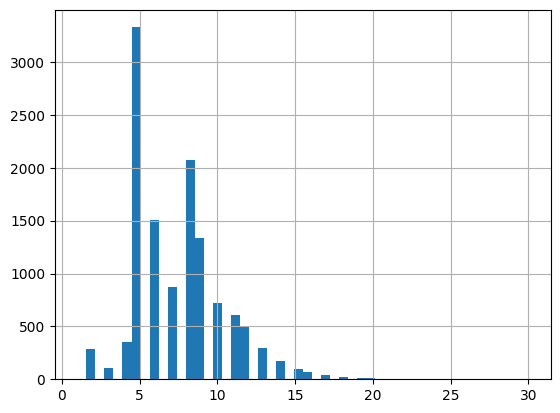

In [43]:
print('✅ train_df')

print("🔎 ''(빈 문자열) topic 개수 :", (train_df["topic_stripped"] == "").sum())

print("\n🔎 topic 길이 분포")
display(train_df["topic_len"].describe())
display(train_df["topic_len"].hist(bins=50))

# 비정상적으로 긴 topic 확인 (예: 상위 1% 이상)
t_q99_train = train_df["topic_len"].quantile(0.99)
weird_topic_train = train_df[train_df["topic_len"] >= t_q99_train]

print(f"⚠️ topic_len 상위 1% 이상 (threshold={t_q99_train}) 샘플 :", weird_topic_train[["fname", "topic", "topic_len"]].shape[0])
display(weird_topic_train.sort_values("topic_len", ascending=False)[["fname", "topic", "topic_len"]].head(20))


print('✅ val_df')

print("🔎 ''(빈 문자열) topic 개수 :", (val_df["topic_stripped"] == "").sum())

print("\n🔎 topic 길이 분포")
display(val_df["topic_len"].describe())

# 비정상적으로 긴 topic 확인 (예: 상위 1% 이상)
t_q99_val = val_df["topic_len"].quantile(0.99)
weird_topic_val = val_df[val_df["topic_len"] >= t_q99_val]

print(f"⚠️ topic_len 상위 1% 이상 (threshold={t_q99_val}) 샘플 :", weird_topic_val[["fname", "topic", "topic_len"]].shape[0])
display(weird_topic_val.sort_values("topic_len", ascending=False)[["fname", "topic", "topic_len"]].head(10))

In [44]:
# 비슷한데 다르게 저장되어 있는 topic이 있는지 확인
topic_counts_train = train_df["topic_stripped"].value_counts()
topic_counts_val = val_df["topic_stripped"].value_counts()

print("📊 topic 상위 30개")
print("✅ train_df | 총 :", topic_counts_train.shape[0])
display(topic_counts_train.head(30))

print("\n✅ val_df | 총 :", topic_counts_val.shape[0])
display(topic_counts_val.head(30))

# 있음! ex. 호텔 예약 vs 호텔 객실 예약 등
# 근데 이거를 어떻게 다 찾고, 어떻게 취합해야 할지...

📊 topic 상위 30개
✅ train_df | 총 : 9209


topic_stripped
음식 주문        130
취업 면접        108
길 안내          66
호텔 체크인        40
일상 대화         29
아파트 임대        29
쇼핑            27
주말 계획         26
호텔 예약         25
여행 계획         23
면접            23
항공권 예약        22
영화 감상         21
휴가 계획         21
작별 인사         21
택시 이용         20
가격 협상         20
영화 관람 계획      18
파티 초대         16
의료 상담         16
환전            15
호텔 객실 예약      15
호텔 체크아웃       15
저녁 초대         15
길 묻기          15
레스토랑 예약       14
체중 감량         14
음료 주문         14
호텔 방 예약       14
전화 메시지 전달     14
Name: count, dtype: int64


✅ val_df | 총 : 474


topic_stripped
호텔 방 예약        5
취업 면접          4
길 안내           4
음식 주문          4
아파트 임대 협상      2
신발 구매          2
비행기 예약         2
일상 대화          2
꿈의 집           2
애완동물 선택        2
버스 이용          2
계산서 오류         2
가격 협상          2
월급 인상          2
약속 지각          2
시험 주문 협상       1
고혈압 관리         1
향후 일정 조율       1
생일 선물 불만       1
책 빌리기          1
이탈리아 여행        1
침실 세트 구매       1
쇼핑 영수증 문제      1
아파트 임대         1
운동과 기분         1
스테레오 보증        1
여행 서비스 불만      1
교통법규 위반        1
룸서비스 요청        1
사천 훠궈 가게 방문    1
Name: count, dtype: int64

In [45]:
# 토픽 별 빈도 구간으로 나누어보기
def bucket_count(c):
    if c >= 300:
        return "300+"
    elif c >= 200:
        return "200~299"
    elif c >= 100:
        return "100~199"
    elif c >= 50:
        return "50~99"
    elif c >= 20:
        return "20~49"
    else:
        return "<20"
    
topic_bucket_train = topic_counts_train.to_frame(name="count")
topic_bucket_train["bucket"] = topic_bucket_train["count"].apply(bucket_count)
topic_bucket_val = topic_counts_val.to_frame(name="count")
topic_bucket_val["bucket"] = topic_bucket_val["count"].apply(bucket_count)

top_10_ratio_train = topic_counts_train.head(10).sum() / len(train_df)
rare_topics_train = topic_counts_train[topic_counts_train < 5]
rare_sample_train = train_df[train_df["topic_stripped"].isin(rare_topics_train.index)].sample(min(20, len(rare_topics_train)), random_state=42)
top_10_ratio_val = topic_counts_val.head(10).sum() / len(val_df)
rare_topics_val = topic_counts_val[topic_counts_val < 5]
rare_sample_val = val_df[val_df["topic_stripped"].isin(rare_topics_val.index)].sample(min(20, len(rare_topics_val)), random_state=42)

In [46]:
print("✅ train_df")
print("📊 topic 빈도 통계")
display(topic_counts_train.describe())

print("📊 topic 빈도 구간별 개수")
display(topic_bucket_train["bucket"].value_counts())

print("\n🔎 topic 빈도 상위 10개 | 총 :", topic_counts_train.shape[0])
print(f"    - 상위 10개 topic이 전체 데이터에서 차지하는 비율 : {top_10_ratio_train:.3f}")         # 많지는 않은 듯?
display(topic_counts_train.head(10))

print("⚠️ 빈도 5 미만 rare topic 개수 :", len(rare_topics_train))
display(rare_sample_train[["fname", "topic_stripped", "summary"]].head(10))

print("✅ val_df")
print("📊 topic 빈도 통계")
display(topic_counts_val.describe())

print("📊 topic 빈도 구간별 개수")
display(topic_bucket_val["bucket"].value_counts())

print("\n🔎 topic 빈도 상위 10개 | 총 :", topic_counts_val.shape[0])
print(f"    - 상위 10개 topic이 전체 데이터에서 차지하는 비율 : {top_10_ratio_val:.3f}")         # 많지는 않은 듯?
display(topic_counts_val.head(10))

print("⚠️ 빈도 5 미만 rare topic 개수 :", len(rare_topics_val))
display(rare_sample_val[["fname", "topic_stripped", "summary"]].head(10))

# 진짜로 “매우 특수한 상황이라 rare인 topic”인지
# 아니면 오타 / 표현 차이로 쪼개진 건지 감이 와.

✅ train_df
📊 topic 빈도 통계


count    9209.000000
mean        1.347595
std         2.357686
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       130.000000
Name: count, dtype: float64

📊 topic 빈도 구간별 개수


bucket
<20        9192
20~49        14
100~199       2
50~99         1
Name: count, dtype: int64


🔎 topic 빈도 상위 10개 | 총 : 9209
    - 상위 10개 topic이 전체 데이터에서 차지하는 비율 : 0.041


topic_stripped
음식 주문     130
취업 면접     108
길 안내       66
호텔 체크인     40
일상 대화      29
아파트 임대     29
쇼핑         27
주말 계획      26
호텔 예약      25
여행 계획      23
Name: count, dtype: int64

⚠️ 빈도 5 미만 rare topic 개수 : 9009


,fname,topic_stripped,summary
8454,train_8483,비행기 대기 중 대화,#Person1#과 #Person2#는 비행기를 기다리며 목적지에 대해 대화합니다....
3249,train_3261,조깅과 해변 활동,Peter는 새로 이사한 집에서 Miss James를 새 이웃으로 만나 조깅하기 좋...
1472,train_1476,불길한 숫자,#Person2#는 본머스로 가는 다음 기차가 13번 플랫폼에서 출발한다고 #Per...
43,train_43,지하철 책 공유,"에드워드는 지하철에 놓인 책을 보고 기뻐하며, 자신의 책을 공유할 계획을 세운다."
10645,train_10682,급여 협상,Thomas와 Monica는 그녀의 예상 급여와 복지에 대해 논의합니다. 최종적으로...
11810,train_11857,통관 절차,"#Person1#은 #Person2#의 여권, 출발지, 여행 목적, 체류 기간, 신..."
11125,train_11167,무료 중국 여행,Lily가 중국어 대회에서 우승하여 상으로 무료 중국 여행을 얻었다. David는 ...
5098,train_5113,여행 예산 분할,#Person2#가 #Person1#에게 5천 달러의 여행 예산 분할 내역을 설명합...
10479,train_10516,에세이 주제 토론,Julia는 에세이를 정리하기 위해 교수의 도움을 요청합니다. 그녀는 정치 속 여성...
5490,train_5505,캐나다 체류 경험,Barbara는 Richard에게 캐나다에서 연구 프로그램을 돕기 위해 갔다고 말하...


✅ val_df
📊 topic 빈도 통계


count    474.000000
mean       1.050633
std        0.334060
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: count, dtype: float64

📊 topic 빈도 구간별 개수


bucket
<20    474
Name: count, dtype: int64


🔎 topic 빈도 상위 10개 | 총 : 474
    - 상위 10개 topic이 전체 데이터에서 차지하는 비율 : 0.058


topic_stripped
호텔 방 예약      5
취업 면접        4
길 안내         4
음식 주문        4
아파트 임대 협상    2
신발 구매        2
비행기 예약       2
일상 대화        2
꿈의 집         2
애완동물 선택      2
Name: count, dtype: int64

⚠️ 빈도 5 미만 rare topic 개수 : 473


,fname,topic_stripped,summary
459,dev_460,문제 있는 사람과의 거리두기,"#Person1#은 #Person2#에게 어떤 남자와 거리를 두라고 권유하고, #P..."
74,dev_74,주차 공간 문제,#Person1#은 #Person2#에게 자신의 주차 공간에 주차한 차를 이동해달라...
313,dev_313,만족스러운 헤어 스타일,"#Person1#은 헤어 스타일에 만족하며, 55달러를 지불했습니다."
177,dev_177,영화 티켓 예약,#Person2#는 #Person1#이 토요일에 Dark and Stormy Nig...
335,dev_335,향후 일정 조율,#Person2#가 #Person1#에게 향후 이틀간의 일정과 계획을 설명한다.
207,dev_207,처방전 수령 및 약 복용 상담,#Person1#은 처방전을 받기 위해 #Person2#를 방문합니다. 또한 #Pe...
157,dev_157,옷 쇼핑과 교환,#Person2#는 #Person1#이 매일 옷을 고민하는 것에 대해 체념하고 있습...
55,dev_55,소음 불만,Mr. Black은 아이들의 소음에 대해 Mr. Brown에게 불평합니다.
323,dev_323,길 안내,"#Person2#는 #Person1#에게 슈퍼마켓, 세탁소 및 이발소의 위치를 알려..."
9,dev_9,꿈의 집,#Person1#과 #Person2#가 Bill Gate의 집에 대해 이야기합니다....


In [47]:
# <20 구간이 엄청 많다 → rare topic이 많다는 뜻
# 이런 rare topic 구간은:
# train / dev split 시 stratified split by topic 고려
# 또는 데이터 증강, oversampling 후보

In [48]:
# ✅ 2. Topic 출현 빈도 분석 → prefix의 필요성 판단

# 📌 관찰
# topic 종류는 거의 9,200개 (엄청 다양함)
# top10 topic 비율은 4% 정도밖에 안 됨
# 대부분 topic은 rare class (빈도 1이 7~8천개)

# 즉,
# topic은 label 역할보다는 "히ント/맥락 정보" 역할이 더 큼.
# 이 말은
# prefix를 붙이는 게 모델에게 강한 inductive bias(주제 힌트)를 줘서 도움이 될 가능성이 큼.

# 특히 rare topic이 너무 많기 때문에:
# dialogue만 보면 요약 방향을 잡기 어렵지만
# topic을 앞에 붙여주면 summary alignment가 좋아질 수 있음.

# ✅ 실제 결과 : LB 점수가 오히려 떨어짐
# train, valid 데이터에서는 topic을 prefix로 학습했지만, test 데이터에는 topic이 없기 때문에 오히려 하락한 것으로 예측
# pesudo-topic을 붙여주는 classifier를 구현할 수 있지만, topic 정규화 및 클러스터링 작업이 필요함 > 제대로 수행되지 않으면 pesudo-topic이 오히려 노이즈로 작용할 가능성도 존재함.
# 따라서 classifier의 적용은 대회 후반부, 최후의 방법으로 남겨놓는 것으로 결정.

In [49]:
# topic별 summary key token 보기
topic_token_stats_train = {}
topic_token_stats_val = {}

for t in train_df["topic"].unique():
    sub = train_df[train_df["topic"] == t]
    tokens = []
    for s in sub["summary"]:
        tokens.extend(simple_tokenize(s))
    freq = Counter([tok for tok in tokens if is_meaningful_token(tok)])
    topic_token_stats_train[t] = freq

for t in val_df["topic"].unique():
    sub = val_df[val_df["topic"] == t]
    tokens = []
    for u in sub["summary"]:
        tokens.extend(simple_tokenize(u))
    freq = Counter([tok for tok in tokens if is_meaningful_token(tok)])
    topic_token_stats_val[t] = freq

# topic 별 상위 토큰 보기
t = "취업 면접"                 # 다른 topic도 확인해보기
print(f"🔎 Topic = {t} 의 summary 핵심 토큰")
print("✅ train_df")
for tok, cnt in topic_token_stats_train[t].most_common(10):
    print(f"{tok:15} {cnt}")
print("\n✅ val_df")
for tok, cnt in topic_token_stats_val[t].most_common(10):
    print(f"{tok:15} {cnt}")

🔎 Topic = 취업 면접 의 summary 핵심 토큰
✅ train_df
person1         110
person2         109
대해              47
에게              41
mr              31
설명합니다           29
자신의             18
면접을             14
이유를             13
있다고             12

✅ val_df
person2         5
person1         5
대해              4
자신의             2
에게              1
미래              1
계획과             1
이전              1
업무              1
경험에             1


In [50]:
# Topic과 Summary 관계

print("✅ train_df")

print("📊 topic 문자열이 summary에 '직접 등장'하는 비율")
display(train_df["topic_in_summary"].value_counts(normalize=True).rename(lambda x: "포함" if x else "미포함").mul(100).round(2))

print("🔎 topic별 topic-in-summary 비율 (상위 10개)")
topic_stats = (train_df.groupby("topic")["topic_in_summary"].mean().sort_values(ascending=False).head(10).mul(100).round(2))
display(topic_stats)

print("📊 topic 단어가 summary에 '반영'되는 비율")
display(train_df["topic_coverage"].describe())

# coverage가 낮은 샘플 몇 개 확인
low_cov = train_df[train_df["topic_coverage"] < 0.5].sample(3, random_state=42)

for i, row in low_cov.iterrows():
    print("🔎 topic 단어가 summary에 반영되지 않은 케이스")
    print(f"[fname]             {row['fname']}")
    print(f"[topic]             {row['topic']}")
    print(f"[summary]           {row['summary']}")
    print(f"[topic_coverage]    {row['topic_coverage']:.2f}\n")


print("✅ val_df")

print("📊 topic 문자열이 summary에 '직접 등장'하는 비율")
display(val_df["topic_in_summary"].value_counts(normalize=True).rename(lambda x: "포함" if x else "미포함").mul(100).round(2))

print("🔎 topic별 topic-in-summary 비율 (상위 10개)")
topic_stats = (val_df.groupby("topic")["topic_in_summary"].mean().sort_values(ascending=False).head(10).mul(100).round(2))
display(topic_stats)

print("📊 topic 단어가 summary에 '반영'되는 비율")
display(val_df["topic_coverage"].describe())

# coverage가 낮은 샘플 몇 개 확인
low_cov = val_df[val_df["topic_coverage"] < 0.5].sample(3, random_state=42)

for i, row in low_cov.iterrows():
    print("🔎 topic 단어가 summary에 반영되지 않은 케이스")
    print(f"[fname]             {row['fname']}")
    print(f"[topic]             {row['topic']}")
    print(f"[summary]           {row['summary']}")
    print(f"[topic_coverage]    {row['topic_coverage']:.2f}\n")

✅ train_df
📊 topic 문자열이 summary에 '직접 등장'하는 비율


topic_in_summary
미포함    90.31
포함      9.69
Name: proportion, dtype: float64

🔎 topic별 topic-in-summary 비율 (상위 10개)


topic
배수 문제        100.0
용선 축제        100.0
포럼 토론        100.0
차고 세일        100.0
사격           100.0
과속           100.0
장학금          100.0
평화봉사단        100.0
평생 교육        100.0
스페인 가족 여행    100.0
Name: topic_in_summary, dtype: float64

📊 topic 단어가 summary에 '반영'되는 비율


count    12410.000000
mean         0.581523
std          0.345886
min          0.000000
25%          0.333333
50%          0.500000
75%          1.000000
max          1.000000
Name: topic_coverage, dtype: float64

🔎 topic 단어가 summary에 반영되지 않은 케이스
[fname]             train_6245
[topic]             약속 불이행
[summary]           #Person2#는 그가 나타나지 않은 이유가 끔찍하고 예기치 못한 사고 때문이라고 생각합니다. #Person1#는 이에 동의하지 않습니다.
[topic_coverage]    0.00

🔎 topic 단어가 summary에 반영되지 않은 케이스
[fname]             train_5934
[topic]             할머니의 생활
[summary]           #Person2#는 #Person1#에게 할머니가 켄터키에서 혼자 살고 있으며 스스로 잘 돌보신다고 말합니다. #Person1#은 가족 없이 외로우시지 않을까 염려하지만, #Person2#는 할머니께서 동네에 친구가 많고 가족과 수시로 연락한다고 설명합니다.
[topic_coverage]    0.00

🔎 topic 단어가 summary에 반영되지 않은 케이스
[fname]             train_3400
[topic]             전화 통화 요청
[summary]           듀이 씨가 해일러 씨와 통화하려고 했으나 해일러 씨가 자리에 없다는 것을 알게 됩니다. 듀이 씨는 메시지를 남깁니다.
[topic_coverage]    0.33

✅ val_df
📊 topic 문자열이 summary에 '직접 등장'하는 비율


topic_in_summary
미포함    90.36
포함      9.64
Name: proportion, dtype: float64

🔎 topic별 topic-in-summary 비율 (상위 10개)


topic
인터넷 설치      100.0
건강한 식단      100.0
새 원피스       100.0
아름다운 서예     100.0
예금 계좌 개설    100.0
결혼식         100.0
모자 퍼레이드     100.0
모래 폭풍       100.0
수업 등록       100.0
저녁 식사       100.0
Name: topic_in_summary, dtype: float64

📊 topic 단어가 summary에 '반영'되는 비율


count    498.000000
mean       0.580154
std        0.335938
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: topic_coverage, dtype: float64

🔎 topic 단어가 summary에 반영되지 않은 케이스
[fname]             dev_218
[topic]             집안일
[summary]           #Person1#이 엄마를 도와 요리를 준비하고 있습니다. 엄마는 #Person1#에게 아빠와 다니엘이 무엇을 하고 있는지 묻습니다.
[topic_coverage]    0.00

🔎 topic 단어가 summary에 반영되지 않은 케이스
[fname]             dev_163
[topic]             직장 내 스트레스
[summary]           에밀리는 #Person1#에게 매니저가 실수를 자신에게 뒤집어씌운 탓에 나쁜 하루를 보냈다고 이야기한다. 에밀리는 매니저가 모두에게 특히 자신에게 불공평하게 대하지만, 승진할 때까지 참아보겠다고 한다. #Person1#은 에밀리가 현명하다고 생각한다.
[topic_coverage]    0.00

🔎 topic 단어가 summary에 반영되지 않은 케이스
[fname]             dev_62
[topic]             잘못 내린 정류장
[summary]           #Person1#과 #Person2#는 #Person2#의 판단 실수로 인해 버스에서 너무 일찍 내렸습니다.
[topic_coverage]    0.00



In [51]:
# ✅ 3. Topic이 summary에 등장하는 비율 분석

# 📌 아주 중요한 숫자 두 개
# topic 문자열이 summary에 “직접 등장”하는 비율: ~9.6%
# topic 단어가 summary에 “반영되는 비율”: mean ≈ 0.58

# 이 말은?
# summary가 topic을 직접 쓰지는 않지만
# summary의 정보는 topic의 의미와 많이 겹침 (58% overlap)

# 즉:
# topic은 summary가 담아야 할 의미적 방향을 제공하는 역할을 아주 잘 수행한다.
# → prefix로 붙여주면 summary alignment↑ 가능성이 매우 높다.

# 여기서 결정적으로 중요한 해석:
# ✔ summary에 topic이 직접 등장하지 않는다고 해서 "topic이 쓸모없다"가 아니다
# → summary는 topic을 paraphrase하거나 관련된 의미만 반영하는 경우가 많음
# → 즉, topic은 “의미적으로 유익한 힌트” 역할을 한다.
# 그래서 prefix는 충분히 가치 있음.

# ⭐ topic prefix를 쓰는 게 도움이 될 확률이 매우 높다는 증거
# EDA 전체 패턴을 보면:
# topic 길이는 짧고, 잘릴 걱정 없음
# topic 종류는 매우 다양하므로 모델이 “summary 방향”을 예측하기 힘들다
# summary는 topic을 직접 쓰진 않아도 의미적으로는 topic과 58% 정도 align됨

# 즉, topic prefix는 불필요한 정보가 아니고, summary를 도울 가능성이 매우 높음
# 이건 LLM summarization 대회에서 prefix가 도움이 되는 대표적인 패턴이다.

In [52]:
# print("\n🔎 topic별 summary 예시 (topic마다 최대 3개)")
# for t in train_df["topic"].dropna().unique()[:5]:
#     sub = train_df[train_df["topic"] == t]
#     n = min(3, len(sub))          # 데이터 개수보다 많이 뽑지 않기
#     if n == 0:
#         continue
#     print(f"\n✅ Topic: {t} (n={len(sub)})")
#     sample = sub.sample(n=n, random_state=42)
#     display(sample[["fname", "summary"]])

In [53]:
# test_df에는 "topic"이 따로 없는데 이것도 지정해주면 요약을 더 정확히 하는데 도움이 될까?

# topic classifier + topic-consistent summarization (멀티 인풋 방식)

# ⭐ 마지막 결론
# test.csv에 topic이 없어도 topic을 예측해서 넣는 구조는 오히려 성능 최강 전략이다.
# ✔ 요약의 품질을 강하게 안정시키고
# ✔ summary의 형태를 topic별 평균 스타일에 가깝게 유지시킴
# ✔ LB 점수 상승 확률 매우 높음